In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess import get_data
from single_search import search_model_eval, combine

# tf.config.run_functions_eagerly(False)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [6]:
%matplotlib inline
NUM_SAMPLES = 10000
plate = np.load('../../real_filtered.npy')

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data= data - data.min()
    data = data/data.max()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,256,1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

data = abs(create_full_cadence(create_true, plate = plate, samples =  NUM_SAMPLES, snr_base=300, snr_range=20,factor=1))
data = combine(load_data_ED(data))
print(data.shape)

true_data = abs(create_full_cadence(create_true, plate = plate, samples = NUM_SAMPLES*6, snr_base=300, snr_range=20, factor=1))
true_data = load_data_ED(true_data)

cadence_set = ['../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_58929_GJ380_fine.h5',
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59291_HIP48887_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59650_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60004_HIP48924_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60354_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60706_HIP48954_fine.h5"
                ]

false_data_1 = get_data(cadence_set, 1543, 1678)
false_data_0 = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES*6, snr_base=300, snr_range=20))
false_data_0 = load_data_ED(false_data_0)

false_data = np.concatenate((false_data_1[:50000],false_data_0[:10000]), axis=0)

(10000, 6, 16, 256)
(60000, 16, 256, 1)


ValueError: You must add noise in the image to specify SNR!

In [6]:
NUM_SAMPLES_TEST=1000
data_test = abs(create_full_cadence(create_true, plate = plate, samples =  NUM_SAMPLES_TEST, snr_base=300, snr_range=20,factor=1))
start = time.time()
data_test = combine(load_data_ED(data_test))
print(data_test.shape)

true_data_test = abs(create_full_cadence(create_true, plate = plate, samples = NUM_SAMPLES_TEST*6, snr_base=300, snr_range=20, factor=1))
start = time.time()
true_data_test = load_data_ED(true_data_test)

cadence_set = ['../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_58929_GJ380_fine.h5',
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59291_HIP48887_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_59650_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60004_HIP48924_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60354_GJ380_fine.h5",
                "../../../../../../../mnt_blpd7/datax2/dl/GBT_57636_60706_HIP48954_fine.h5"
                ]
false_data_test_1 = get_data(cadence_set, 1260, 1276)

false_data_test_0 = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES_TEST*6, snr_base=300, snr_range=20))
start = time.time()
false_data_test_0 = load_data_ED(false_data_test_0)

false_data_test = np.concatenate((false_data_test_1[:5000],false_data_test_0[:1000]), axis=0)

0
(1000, 6, 16, 256)
(6000, 16, 256, 1)
0
1000
2000
3000
4000
5000
(6000, 6, 16, 256)
Getting Data
reshaping Data
Combining Cadence
Data Load Execution Time: 4.423967361450195
0
1000
2000
3000
4000
5000
(6000, 6, 16, 256)


In [22]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,  **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        alpha=100
        beta=1
        self.alpha = alpha
        self.beta = beta
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += 1.5*same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):
#         print(false_data.shape)
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += 1.5*same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(3*true_loss+false_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(true_loss+3*false_loss)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result()
        }

In [23]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [24]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [25]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
def build_model():
    latent_dim = 8
    dens_lay = 512
    kernel = (3,3)
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.Dense(1* 16 * 64, activation="relu")(x)
    x = layers.Reshape((1,16, 64))(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 8, 128, 16)   160         in

In [33]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.h5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

model.fit(x = [data,true_data,false_data ],y= data[:,:,:,:], epochs=2700, batch_size=5000, 
          validation_data=([data_test,true_data_test,false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/2700
12/12 [==============================] - 21s 2s/step - loss: 2256.5258 - reconstruction_loss: 1893.4193 - kl_loss: 97.7841 - false_loss: 0.1052 - true_loss: 1.2206 - val_loss: 6768.1431 - val_reconstruction_loss: 1897.6704 - val_kl_loss: 98.6703 - val_false_loss: 15.4840 - val_true_loss: 1.2662
Epoch 2/2700
12/12 [==============================] - 15s 1s/step - loss: 2257.8291 - reconstruction_loss: 1893.5651 - kl_loss: 97.3764 - false_loss: 0.1052 - true_loss: 1.2206 - val_loss: 6767.4814 - val_reconstruction_loss: 1897.6694 - val_kl_loss: 98.6713 - val_false_loss: 15.4818 - val_true_loss: 1.2661
Epoch 3/2700
12/12 [==============================] - 15s 1s/step - loss: 2251.1651 - reconstruction_loss: 1893.1276 - kl_loss: 97.7497 - false_loss: 0.1052 - true_loss: 1.2205 - val_loss: 6766.8164 - val_reconstruction_loss: 1897.6683 - val_kl_loss: 98.6718 - val_false_loss: 15.4796 - val_true_loss: 1.2661
Epoch 4/2700
12/12 [==============================] - 15s 1s/step - loss:

12/12 [==============================] - 15s 1s/step - loss: 2245.8593 - reconstruction_loss: 1892.9869 - kl_loss: 98.6571 - false_loss: 0.1046 - true_loss: 1.2172 - val_loss: 6734.1802 - val_reconstruction_loss: 1897.6193 - val_kl_loss: 98.6986 - val_false_loss: 15.3719 - val_true_loss: 1.2631
Epoch 54/2700
12/12 [==============================] - 15s 1s/step - loss: 2251.9403 - reconstruction_loss: 1893.4380 - kl_loss: 98.7121 - false_loss: 0.1046 - true_loss: 1.2171 - val_loss: 6733.5327 - val_reconstruction_loss: 1897.6183 - val_kl_loss: 98.6996 - val_false_loss: 15.3697 - val_true_loss: 1.2630
Epoch 55/2700
12/12 [==============================] - 15s 1s/step - loss: 2250.2932 - reconstruction_loss: 1892.9053 - kl_loss: 98.6382 - false_loss: 0.1046 - true_loss: 1.2170 - val_loss: 6732.8779 - val_reconstruction_loss: 1897.6172 - val_kl_loss: 98.7003 - val_false_loss: 15.3676 - val_true_loss: 1.2630
Epoch 56/2700
12/12 [==============================] - 15s 1s/step - loss: 2255.8431

12/12 [==============================] - 15s 1s/step - loss: 2253.2393 - reconstruction_loss: 1893.0848 - kl_loss: 99.9211 - false_loss: 0.1041 - true_loss: 1.2137 - val_loss: 6700.8252 - val_reconstruction_loss: 1897.5698 - val_kl_loss: 98.7323 - val_false_loss: 15.2618 - val_true_loss: 1.2600
Epoch 106/2700
12/12 [==============================] - 15s 1s/step - loss: 2254.0287 - reconstruction_loss: 1892.9972 - kl_loss: 98.3108 - false_loss: 0.1041 - true_loss: 1.2136 - val_loss: 6700.1978 - val_reconstruction_loss: 1897.5688 - val_kl_loss: 98.7322 - val_false_loss: 15.2597 - val_true_loss: 1.2599
Epoch 107/2700
12/12 [==============================] - 15s 1s/step - loss: 2245.3397 - reconstruction_loss: 1892.6342 - kl_loss: 99.2317 - false_loss: 0.1041 - true_loss: 1.2135 - val_loss: 6699.5605 - val_reconstruction_loss: 1897.5679 - val_kl_loss: 98.7314 - val_false_loss: 15.2576 - val_true_loss: 1.2599
Epoch 108/2700
12/12 [==============================] - 15s 1s/step - loss: 2251.7

12/12 [==============================] - 15s 1s/step - loss: 2245.7395 - reconstruction_loss: 1892.9052 - kl_loss: 99.5101 - false_loss: 0.1035 - true_loss: 1.2102 - val_loss: 6668.2124 - val_reconstruction_loss: 1897.5208 - val_kl_loss: 98.7642 - val_false_loss: 15.1541 - val_true_loss: 1.2569
Epoch 158/2700
12/12 [==============================] - 15s 1s/step - loss: 2246.1509 - reconstruction_loss: 1892.6766 - kl_loss: 98.5824 - false_loss: 0.1035 - true_loss: 1.2102 - val_loss: 6667.5840 - val_reconstruction_loss: 1897.5198 - val_kl_loss: 98.7635 - val_false_loss: 15.1521 - val_true_loss: 1.2569
Epoch 159/2700
12/12 [==============================] - 15s 1s/step - loss: 2248.8690 - reconstruction_loss: 1892.5439 - kl_loss: 99.3308 - false_loss: 0.1035 - true_loss: 1.2101 - val_loss: 6666.9629 - val_reconstruction_loss: 1897.5189 - val_kl_loss: 98.7631 - val_false_loss: 15.1500 - val_true_loss: 1.2568
Epoch 160/2700
12/12 [==============================] - 15s 1s/step - loss: 2250.0

12/12 [==============================] - 16s 1s/step - loss: 2246.6426 - reconstruction_loss: 1893.2374 - kl_loss: 97.9790 - false_loss: 0.1030 - true_loss: 1.2068 - val_loss: 6636.2783 - val_reconstruction_loss: 1897.4724 - val_kl_loss: 98.7717 - val_false_loss: 15.0488 - val_true_loss: 1.2539
Epoch 210/2700
12/12 [==============================] - 15s 1s/step - loss: 2244.0404 - reconstruction_loss: 1892.5812 - kl_loss: 99.7700 - false_loss: 0.1030 - true_loss: 1.2067 - val_loss: 6635.6748 - val_reconstruction_loss: 1897.4717 - val_kl_loss: 98.7719 - val_false_loss: 15.0468 - val_true_loss: 1.2539
Epoch 211/2700
12/12 [==============================] - 16s 1s/step - loss: 2247.6767 - reconstruction_loss: 1892.7626 - kl_loss: 99.0549 - false_loss: 0.1029 - true_loss: 1.2067 - val_loss: 6635.0610 - val_reconstruction_loss: 1897.4705 - val_kl_loss: 98.7721 - val_false_loss: 15.0448 - val_true_loss: 1.2538
Epoch 212/2700
12/12 [==============================] - 15s 1s/step - loss: 2242.6

12/12 [==============================] - 17s 1s/step - loss: 2238.3562 - reconstruction_loss: 1892.5709 - kl_loss: 100.1722 - false_loss: 0.1024 - true_loss: 1.2034 - val_loss: 6604.8359 - val_reconstruction_loss: 1897.4244 - val_kl_loss: 98.7879 - val_false_loss: 14.9451 - val_true_loss: 1.2509
Epoch 262/2700
12/12 [==============================] - 15s 1s/step - loss: 2243.1326 - reconstruction_loss: 1892.4517 - kl_loss: 99.7232 - false_loss: 0.1024 - true_loss: 1.2033 - val_loss: 6604.2275 - val_reconstruction_loss: 1897.4236 - val_kl_loss: 98.7876 - val_false_loss: 14.9431 - val_true_loss: 1.2509
Epoch 263/2700
12/12 [==============================] - 15s 1s/step - loss: 2238.2039 - reconstruction_loss: 1892.5060 - kl_loss: 100.7355 - false_loss: 0.1024 - true_loss: 1.2032 - val_loss: 6603.6235 - val_reconstruction_loss: 1897.4224 - val_kl_loss: 98.7868 - val_false_loss: 14.9411 - val_true_loss: 1.2508
Epoch 264/2700
12/12 [==============================] - 15s 1s/step - loss: 2247

12/12 [==============================] - 16s 1s/step - loss: 2245.6708 - reconstruction_loss: 1892.6056 - kl_loss: 99.1101 - false_loss: 0.1019 - true_loss: 1.2000 - val_loss: 6573.8979 - val_reconstruction_loss: 1897.3768 - val_kl_loss: 98.7953 - val_false_loss: 14.8431 - val_true_loss: 1.2480
Epoch 314/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.1080 - reconstruction_loss: 1892.1115 - kl_loss: 99.6437 - false_loss: 0.1019 - true_loss: 1.2000 - val_loss: 6573.3086 - val_reconstruction_loss: 1897.3760 - val_kl_loss: 98.7956 - val_false_loss: 14.8411 - val_true_loss: 1.2480
Epoch 315/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.7198 - reconstruction_loss: 1892.5155 - kl_loss: 99.9977 - false_loss: 0.1019 - true_loss: 1.1999 - val_loss: 6572.7139 - val_reconstruction_loss: 1897.3750 - val_kl_loss: 98.7952 - val_false_loss: 14.8392 - val_true_loss: 1.2479
Epoch 316/2700
12/12 [==============================] - 16s 1s/step - loss: 2243.7

12/12 [==============================] - 16s 1s/step - loss: 2264.4937 - reconstruction_loss: 1892.5958 - kl_loss: 96.4148 - false_loss: 0.1014 - true_loss: 1.1967 - val_loss: 6543.4663 - val_reconstruction_loss: 1897.3313 - val_kl_loss: 98.8033 - val_false_loss: 14.7427 - val_true_loss: 1.2452
Epoch 366/2700
12/12 [==============================] - 16s 1s/step - loss: 2260.0125 - reconstruction_loss: 1892.1250 - kl_loss: 96.6805 - false_loss: 0.1013 - true_loss: 1.1967 - val_loss: 6542.8838 - val_reconstruction_loss: 1897.3306 - val_kl_loss: 98.8039 - val_false_loss: 14.7408 - val_true_loss: 1.2451
Epoch 367/2700
12/12 [==============================] - 16s 1s/step - loss: 2259.6432 - reconstruction_loss: 1892.3145 - kl_loss: 96.6707 - false_loss: 0.1013 - true_loss: 1.1966 - val_loss: 6542.3062 - val_reconstruction_loss: 1897.3295 - val_kl_loss: 98.8024 - val_false_loss: 14.7389 - val_true_loss: 1.2451
Epoch 368/2700
12/12 [==============================] - 15s 1s/step - loss: 2264.8

12/12 [==============================] - 16s 1s/step - loss: 2239.8646 - reconstruction_loss: 1892.3846 - kl_loss: 99.9467 - false_loss: 0.1008 - true_loss: 1.1935 - val_loss: 6513.4785 - val_reconstruction_loss: 1897.2863 - val_kl_loss: 98.8146 - val_false_loss: 14.6438 - val_true_loss: 1.2424
Epoch 418/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.1310 - reconstruction_loss: 1892.0602 - kl_loss: 99.7857 - false_loss: 0.1008 - true_loss: 1.1934 - val_loss: 6512.8965 - val_reconstruction_loss: 1897.2853 - val_kl_loss: 98.8148 - val_false_loss: 14.6419 - val_true_loss: 1.2423
Epoch 419/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.4313 - reconstruction_loss: 1892.3828 - kl_loss: 99.6703 - false_loss: 0.1008 - true_loss: 1.1934 - val_loss: 6512.3223 - val_reconstruction_loss: 1897.2844 - val_kl_loss: 98.8149 - val_false_loss: 14.6400 - val_true_loss: 1.2423
Epoch 420/2700
12/12 [==============================] - 16s 1s/step - loss: 2239.9

12/12 [==============================] - 16s 1s/step - loss: 2243.4250 - reconstruction_loss: 1892.0575 - kl_loss: 97.3694 - false_loss: 0.1003 - true_loss: 1.1903 - val_loss: 6483.8140 - val_reconstruction_loss: 1897.2428 - val_kl_loss: 98.8247 - val_false_loss: 14.5460 - val_true_loss: 1.2396
Epoch 470/2700
12/12 [==============================] - 15s 1s/step - loss: 2238.6058 - reconstruction_loss: 1891.7394 - kl_loss: 98.2792 - false_loss: 0.1003 - true_loss: 1.1902 - val_loss: 6483.2456 - val_reconstruction_loss: 1897.2419 - val_kl_loss: 98.8242 - val_false_loss: 14.5441 - val_true_loss: 1.2395
Epoch 471/2700
12/12 [==============================] - 16s 1s/step - loss: 2237.7675 - reconstruction_loss: 1891.8568 - kl_loss: 98.4287 - false_loss: 0.1003 - true_loss: 1.1901 - val_loss: 6482.6768 - val_reconstruction_loss: 1897.2412 - val_kl_loss: 98.8239 - val_false_loss: 14.5422 - val_true_loss: 1.2395
Epoch 472/2700
12/12 [==============================] - 15s 1s/step - loss: 2237.9

12/12 [==============================] - 15s 1s/step - loss: 2249.0988 - reconstruction_loss: 1892.4188 - kl_loss: 98.8792 - false_loss: 0.0998 - true_loss: 1.1870 - val_loss: 6454.5464 - val_reconstruction_loss: 1897.2004 - val_kl_loss: 98.8295 - val_false_loss: 14.4495 - val_true_loss: 1.2368
Epoch 522/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.5675 - reconstruction_loss: 1892.4199 - kl_loss: 99.7376 - false_loss: 0.0998 - true_loss: 1.1869 - val_loss: 6453.9844 - val_reconstruction_loss: 1897.1996 - val_kl_loss: 98.8295 - val_false_loss: 14.4476 - val_true_loss: 1.2367
Epoch 523/2700
12/12 [==============================] - 16s 1s/step - loss: 2236.9049 - reconstruction_loss: 1892.0459 - kl_loss: 99.4099 - false_loss: 0.0998 - true_loss: 1.1869 - val_loss: 6453.4238 - val_reconstruction_loss: 1897.1989 - val_kl_loss: 98.8300 - val_false_loss: 14.4458 - val_true_loss: 1.2367
Epoch 524/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.5

12/12 [==============================] - 15s 1s/step - loss: 2236.2287 - reconstruction_loss: 1892.2789 - kl_loss: 100.3551 - false_loss: 0.0993 - true_loss: 1.1838 - val_loss: 6425.6890 - val_reconstruction_loss: 1897.1578 - val_kl_loss: 98.8561 - val_false_loss: 14.3543 - val_true_loss: 1.2339
Epoch 574/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.9396 - reconstruction_loss: 1892.1429 - kl_loss: 99.3974 - false_loss: 0.0993 - true_loss: 1.1837 - val_loss: 6425.1558 - val_reconstruction_loss: 1897.1573 - val_kl_loss: 98.8572 - val_false_loss: 14.3525 - val_true_loss: 1.2339
Epoch 575/2700
12/12 [==============================] - 15s 1s/step - loss: 2246.9480 - reconstruction_loss: 1892.4352 - kl_loss: 98.6949 - false_loss: 0.0993 - true_loss: 1.1836 - val_loss: 6424.6099 - val_reconstruction_loss: 1897.1565 - val_kl_loss: 98.8587 - val_false_loss: 14.3507 - val_true_loss: 1.2338
Epoch 576/2700
12/12 [==============================] - 15s 1s/step - loss: 2244.

12/12 [==============================] - 15s 1s/step - loss: 2250.8410 - reconstruction_loss: 1892.0933 - kl_loss: 99.0707 - false_loss: 0.0988 - true_loss: 1.1805 - val_loss: 6397.2197 - val_reconstruction_loss: 1897.1167 - val_kl_loss: 98.8736 - val_false_loss: 14.2604 - val_true_loss: 1.2311
Epoch 626/2700
12/12 [==============================] - 15s 1s/step - loss: 2253.6043 - reconstruction_loss: 1892.2233 - kl_loss: 99.2712 - false_loss: 0.0988 - true_loss: 1.1805 - val_loss: 6396.6738 - val_reconstruction_loss: 1897.1160 - val_kl_loss: 98.8748 - val_false_loss: 14.2586 - val_true_loss: 1.2311
Epoch 627/2700
12/12 [==============================] - 15s 1s/step - loss: 2240.3916 - reconstruction_loss: 1891.6553 - kl_loss: 99.1722 - false_loss: 0.0988 - true_loss: 1.1804 - val_loss: 6396.1299 - val_reconstruction_loss: 1897.1150 - val_kl_loss: 98.8761 - val_false_loss: 14.2568 - val_true_loss: 1.2310
Epoch 628/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.3

12/12 [==============================] - 16s 1s/step - loss: 2236.0087 - reconstruction_loss: 1891.8604 - kl_loss: 100.3975 - false_loss: 0.0983 - true_loss: 1.1773 - val_loss: 6369.0283 - val_reconstruction_loss: 1897.0758 - val_kl_loss: 98.9093 - val_false_loss: 14.1674 - val_true_loss: 1.2283
Epoch 678/2700
12/12 [==============================] - 16s 1s/step - loss: 2234.6545 - reconstruction_loss: 1892.0958 - kl_loss: 100.3666 - false_loss: 0.0983 - true_loss: 1.1773 - val_loss: 6368.4932 - val_reconstruction_loss: 1897.0751 - val_kl_loss: 98.9094 - val_false_loss: 14.1656 - val_true_loss: 1.2282
Epoch 679/2700
12/12 [==============================] - 15s 1s/step - loss: 2229.5457 - reconstruction_loss: 1891.3739 - kl_loss: 100.5750 - false_loss: 0.0983 - true_loss: 1.1772 - val_loss: 6367.9521 - val_reconstruction_loss: 1897.0743 - val_kl_loss: 98.9103 - val_false_loss: 14.1638 - val_true_loss: 1.2282
Epoch 680/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2264.9682 - reconstruction_loss: 1891.7072 - kl_loss: 99.0543 - false_loss: 0.0978 - true_loss: 1.1742 - val_loss: 6341.3477 - val_reconstruction_loss: 1897.0367 - val_kl_loss: 98.9317 - val_false_loss: 14.0761 - val_true_loss: 1.2256
Epoch 730/2700
12/12 [==============================] - 15s 1s/step - loss: 2260.1262 - reconstruction_loss: 1891.4452 - kl_loss: 98.5892 - false_loss: 0.0978 - true_loss: 1.1742 - val_loss: 6340.8130 - val_reconstruction_loss: 1897.0360 - val_kl_loss: 98.9321 - val_false_loss: 14.0743 - val_true_loss: 1.2255
Epoch 731/2700
12/12 [==============================] - 15s 1s/step - loss: 2257.9373 - reconstruction_loss: 1891.7758 - kl_loss: 97.0568 - false_loss: 0.0978 - true_loss: 1.1741 - val_loss: 6340.2876 - val_reconstruction_loss: 1897.0353 - val_kl_loss: 98.9327 - val_false_loss: 14.0726 - val_true_loss: 1.2255
Epoch 732/2700
12/12 [==============================] - 15s 1s/step - loss: 2250.9

12/12 [==============================] - 16s 1s/step - loss: 2234.0933 - reconstruction_loss: 1891.6484 - kl_loss: 101.1910 - false_loss: 0.0973 - true_loss: 1.1712 - val_loss: 6314.0381 - val_reconstruction_loss: 1896.9985 - val_kl_loss: 98.9502 - val_false_loss: 13.9860 - val_true_loss: 1.2229
Epoch 782/2700
12/12 [==============================] - 15s 1s/step - loss: 2236.0880 - reconstruction_loss: 1891.5938 - kl_loss: 100.6187 - false_loss: 0.0973 - true_loss: 1.1711 - val_loss: 6313.5186 - val_reconstruction_loss: 1896.9979 - val_kl_loss: 98.9501 - val_false_loss: 13.9843 - val_true_loss: 1.2229
Epoch 783/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.5750 - reconstruction_loss: 1891.4554 - kl_loss: 100.7015 - false_loss: 0.0973 - true_loss: 1.1710 - val_loss: 6312.9956 - val_reconstruction_loss: 1896.9972 - val_kl_loss: 98.9500 - val_false_loss: 13.9826 - val_true_loss: 1.2228
Epoch 784/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2229.4289 - reconstruction_loss: 1891.2826 - kl_loss: 100.3789 - false_loss: 0.0968 - true_loss: 1.1681 - val_loss: 6287.1074 - val_reconstruction_loss: 1896.9607 - val_kl_loss: 98.9776 - val_false_loss: 13.8972 - val_true_loss: 1.2202
Epoch 834/2700
12/12 [==============================] - 15s 1s/step - loss: 2229.9774 - reconstruction_loss: 1891.3405 - kl_loss: 100.8110 - false_loss: 0.0968 - true_loss: 1.1680 - val_loss: 6286.5908 - val_reconstruction_loss: 1896.9598 - val_kl_loss: 98.9790 - val_false_loss: 13.8955 - val_true_loss: 1.2202
Epoch 835/2700
12/12 [==============================] - 15s 1s/step - loss: 2229.7787 - reconstruction_loss: 1891.4493 - kl_loss: 100.8759 - false_loss: 0.0968 - true_loss: 1.1680 - val_loss: 6286.0806 - val_reconstruction_loss: 1896.9592 - val_kl_loss: 98.9805 - val_false_loss: 13.8938 - val_true_loss: 1.2201
Epoch 836/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2235.0945 - reconstruction_loss: 1891.1298 - kl_loss: 100.4285 - false_loss: 0.0964 - true_loss: 1.1650 - val_loss: 6260.5786 - val_reconstruction_loss: 1896.9235 - val_kl_loss: 99.0018 - val_false_loss: 13.8097 - val_true_loss: 1.2175
Epoch 886/2700
12/12 [==============================] - 16s 1s/step - loss: 2240.1595 - reconstruction_loss: 1891.5601 - kl_loss: 100.3684 - false_loss: 0.0964 - true_loss: 1.1650 - val_loss: 6260.0718 - val_reconstruction_loss: 1896.9229 - val_kl_loss: 99.0021 - val_false_loss: 13.8080 - val_true_loss: 1.2175
Epoch 887/2700
12/12 [==============================] - 15s 1s/step - loss: 2234.3700 - reconstruction_loss: 1891.6576 - kl_loss: 100.3276 - false_loss: 0.0964 - true_loss: 1.1649 - val_loss: 6259.5693 - val_reconstruction_loss: 1896.9221 - val_kl_loss: 99.0020 - val_false_loss: 13.8064 - val_true_loss: 1.2174
Epoch 888/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2233.4097 - reconstruction_loss: 1891.2299 - kl_loss: 100.6348 - false_loss: 0.0959 - true_loss: 1.1620 - val_loss: 6234.3398 - val_reconstruction_loss: 1896.8877 - val_kl_loss: 99.0127 - val_false_loss: 13.7232 - val_true_loss: 1.2149
Epoch 938/2700
12/12 [==============================] - 16s 1s/step - loss: 2234.8749 - reconstruction_loss: 1890.7227 - kl_loss: 100.5597 - false_loss: 0.0959 - true_loss: 1.1619 - val_loss: 6233.8384 - val_reconstruction_loss: 1896.8868 - val_kl_loss: 99.0131 - val_false_loss: 13.7215 - val_true_loss: 1.2149
Epoch 939/2700
12/12 [==============================] - 16s 1s/step - loss: 2233.0240 - reconstruction_loss: 1890.9340 - kl_loss: 100.4714 - false_loss: 0.0959 - true_loss: 1.1619 - val_loss: 6233.3335 - val_reconstruction_loss: 1896.8861 - val_kl_loss: 99.0146 - val_false_loss: 13.7199 - val_true_loss: 1.2148
Epoch 940/2700
12/12 [==============================] - 16s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2231.8513 - reconstruction_loss: 1891.4965 - kl_loss: 100.9353 - false_loss: 0.0954 - true_loss: 1.1589 - val_loss: 6208.3687 - val_reconstruction_loss: 1896.8518 - val_kl_loss: 99.0501 - val_false_loss: 13.6375 - val_true_loss: 1.2123
Epoch 990/2700
12/12 [==============================] - 15s 1s/step - loss: 2227.4326 - reconstruction_loss: 1890.9844 - kl_loss: 101.0280 - false_loss: 0.0954 - true_loss: 1.1589 - val_loss: 6207.8696 - val_reconstruction_loss: 1896.8511 - val_kl_loss: 99.0498 - val_false_loss: 13.6359 - val_true_loss: 1.2122
Epoch 991/2700
12/12 [==============================] - 15s 1s/step - loss: 2230.6804 - reconstruction_loss: 1891.1810 - kl_loss: 100.8006 - false_loss: 0.0954 - true_loss: 1.1588 - val_loss: 6207.3745 - val_reconstruction_loss: 1896.8502 - val_kl_loss: 99.0501 - val_false_loss: 13.6342 - val_true_loss: 1.2122
Epoch 992/2700
12/12 [==============================] - 15s 1s/step - loss: 222

12/12 [==============================] - 16s 1s/step - loss: 2229.1332 - reconstruction_loss: 1890.8522 - kl_loss: 100.4877 - false_loss: 0.0950 - true_loss: 1.1560 - val_loss: 6182.7085 - val_reconstruction_loss: 1896.8176 - val_kl_loss: 99.0653 - val_false_loss: 13.5529 - val_true_loss: 1.2096
Epoch 1042/2700
12/12 [==============================] - 15s 1s/step - loss: 2227.5897 - reconstruction_loss: 1890.8302 - kl_loss: 101.6032 - false_loss: 0.0950 - true_loss: 1.1559 - val_loss: 6182.2188 - val_reconstruction_loss: 1896.8168 - val_kl_loss: 99.0656 - val_false_loss: 13.5513 - val_true_loss: 1.2096
Epoch 1043/2700
12/12 [==============================] - 16s 1s/step - loss: 2229.7726 - reconstruction_loss: 1890.7484 - kl_loss: 101.0884 - false_loss: 0.0950 - true_loss: 1.1559 - val_loss: 6181.7295 - val_reconstruction_loss: 1896.8160 - val_kl_loss: 99.0666 - val_false_loss: 13.5497 - val_true_loss: 1.2095
Epoch 1044/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2228.1920 - reconstruction_loss: 1890.5780 - kl_loss: 100.7573 - false_loss: 0.0945 - true_loss: 1.1531 - val_loss: 6157.5112 - val_reconstruction_loss: 1896.7834 - val_kl_loss: 99.0979 - val_false_loss: 13.4698 - val_true_loss: 1.2070
Epoch 1094/2700
12/12 [==============================] - 15s 1s/step - loss: 2224.3109 - reconstruction_loss: 1890.8436 - kl_loss: 101.7783 - false_loss: 0.0945 - true_loss: 1.1530 - val_loss: 6157.0303 - val_reconstruction_loss: 1896.7827 - val_kl_loss: 99.0987 - val_false_loss: 13.4682 - val_true_loss: 1.2070
Epoch 1095/2700
12/12 [==============================] - 16s 1s/step - loss: 2224.5864 - reconstruction_loss: 1890.4974 - kl_loss: 101.6550 - false_loss: 0.0945 - true_loss: 1.1529 - val_loss: 6156.5469 - val_reconstruction_loss: 1896.7821 - val_kl_loss: 99.0991 - val_false_loss: 13.4666 - val_true_loss: 1.2069
Epoch 1096/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2225.1396 - reconstruction_loss: 1891.0414 - kl_loss: 101.3458 - false_loss: 0.0941 - true_loss: 1.1501 - val_loss: 6132.6309 - val_reconstruction_loss: 1896.7505 - val_kl_loss: 99.1203 - val_false_loss: 13.3878 - val_true_loss: 1.2044
Epoch 1146/2700
12/12 [==============================] - 16s 1s/step - loss: 2225.8962 - reconstruction_loss: 1890.4481 - kl_loss: 101.5533 - false_loss: 0.0941 - true_loss: 1.1501 - val_loss: 6132.1528 - val_reconstruction_loss: 1896.7498 - val_kl_loss: 99.1202 - val_false_loss: 13.3862 - val_true_loss: 1.2044
Epoch 1147/2700
12/12 [==============================] - 16s 1s/step - loss: 2229.6593 - reconstruction_loss: 1891.1478 - kl_loss: 101.4389 - false_loss: 0.0941 - true_loss: 1.1500 - val_loss: 6131.6797 - val_reconstruction_loss: 1896.7491 - val_kl_loss: 99.1205 - val_false_loss: 13.3846 - val_true_loss: 1.2043
Epoch 1148/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2224.0416 - reconstruction_loss: 1890.8760 - kl_loss: 102.1345 - false_loss: 0.0936 - true_loss: 1.1472 - val_loss: 6108.1401 - val_reconstruction_loss: 1896.7179 - val_kl_loss: 99.1614 - val_false_loss: 13.3070 - val_true_loss: 1.2018
Epoch 1198/2700
12/12 [==============================] - 16s 1s/step - loss: 2228.9899 - reconstruction_loss: 1890.5680 - kl_loss: 101.5208 - false_loss: 0.0936 - true_loss: 1.1471 - val_loss: 6107.6694 - val_reconstruction_loss: 1896.7172 - val_kl_loss: 99.1622 - val_false_loss: 13.3054 - val_true_loss: 1.2018
Epoch 1199/2700
12/12 [==============================] - 15s 1s/step - loss: 2229.3068 - reconstruction_loss: 1890.3384 - kl_loss: 101.2593 - false_loss: 0.0936 - true_loss: 1.1471 - val_loss: 6107.2031 - val_reconstruction_loss: 1896.7164 - val_kl_loss: 99.1628 - val_false_loss: 13.3039 - val_true_loss: 1.2017
Epoch 1200/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2226.4699 - reconstruction_loss: 1890.5812 - kl_loss: 101.0911 - false_loss: 0.0932 - true_loss: 1.1443 - val_loss: 6084.0933 - val_reconstruction_loss: 1896.6857 - val_kl_loss: 99.1907 - val_false_loss: 13.2277 - val_true_loss: 1.1993
Epoch 1250/2700
12/12 [==============================] - 16s 1s/step - loss: 2224.9302 - reconstruction_loss: 1890.8687 - kl_loss: 102.0550 - false_loss: 0.0932 - true_loss: 1.1443 - val_loss: 6083.6318 - val_reconstruction_loss: 1896.6851 - val_kl_loss: 99.1918 - val_false_loss: 13.2261 - val_true_loss: 1.1993
Epoch 1251/2700
12/12 [==============================] - 16s 1s/step - loss: 2228.4944 - reconstruction_loss: 1891.2797 - kl_loss: 101.3589 - false_loss: 0.0932 - true_loss: 1.1442 - val_loss: 6083.1763 - val_reconstruction_loss: 1896.6844 - val_kl_loss: 99.1933 - val_false_loss: 13.2246 - val_true_loss: 1.1992
Epoch 1252/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2225.8792 - reconstruction_loss: 1890.3680 - kl_loss: 101.6754 - false_loss: 0.0928 - true_loss: 1.1415 - val_loss: 6060.4888 - val_reconstruction_loss: 1896.6545 - val_kl_loss: 99.2263 - val_false_loss: 13.1498 - val_true_loss: 1.1968
Epoch 1302/2700
12/12 [==============================] - 15s 1s/step - loss: 2225.5138 - reconstruction_loss: 1890.7842 - kl_loss: 101.4270 - false_loss: 0.0927 - true_loss: 1.1414 - val_loss: 6060.0293 - val_reconstruction_loss: 1896.6539 - val_kl_loss: 99.2273 - val_false_loss: 13.1483 - val_true_loss: 1.1967
Epoch 1303/2700
12/12 [==============================] - 16s 1s/step - loss: 2226.0679 - reconstruction_loss: 1890.6000 - kl_loss: 101.1548 - false_loss: 0.0927 - true_loss: 1.1413 - val_loss: 6059.5791 - val_reconstruction_loss: 1896.6533 - val_kl_loss: 99.2286 - val_false_loss: 13.1468 - val_true_loss: 1.1967
Epoch 1304/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2224.5378 - reconstruction_loss: 1890.2114 - kl_loss: 100.4635 - false_loss: 0.0923 - true_loss: 1.1387 - val_loss: 6037.2681 - val_reconstruction_loss: 1896.6232 - val_kl_loss: 99.2567 - val_false_loss: 13.0732 - val_true_loss: 1.1943
Epoch 1354/2700
12/12 [==============================] - 15s 1s/step - loss: 2225.5442 - reconstruction_loss: 1890.2831 - kl_loss: 101.3530 - false_loss: 0.0923 - true_loss: 1.1386 - val_loss: 6036.8306 - val_reconstruction_loss: 1896.6224 - val_kl_loss: 99.2567 - val_false_loss: 13.0718 - val_true_loss: 1.1943
Epoch 1355/2700
12/12 [==============================] - 16s 1s/step - loss: 2229.5260 - reconstruction_loss: 1890.6725 - kl_loss: 101.4856 - false_loss: 0.0923 - true_loss: 1.1386 - val_loss: 6036.3921 - val_reconstruction_loss: 1896.6217 - val_kl_loss: 99.2565 - val_false_loss: 13.0703 - val_true_loss: 1.1942
Epoch 1356/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2223.5352 - reconstruction_loss: 1890.3623 - kl_loss: 101.8350 - false_loss: 0.0919 - true_loss: 1.1359 - val_loss: 6014.6426 - val_reconstruction_loss: 1896.5925 - val_kl_loss: 99.2835 - val_false_loss: 12.9986 - val_true_loss: 1.1919
Epoch 1406/2700
12/12 [==============================] - 15s 1s/step - loss: 2222.6086 - reconstruction_loss: 1890.4662 - kl_loss: 101.7423 - false_loss: 0.0919 - true_loss: 1.1359 - val_loss: 6014.2070 - val_reconstruction_loss: 1896.5919 - val_kl_loss: 99.2839 - val_false_loss: 12.9972 - val_true_loss: 1.1918
Epoch 1407/2700
12/12 [==============================] - 15s 1s/step - loss: 2225.3868 - reconstruction_loss: 1890.2490 - kl_loss: 101.5071 - false_loss: 0.0919 - true_loss: 1.1358 - val_loss: 6013.7764 - val_reconstruction_loss: 1896.5914 - val_kl_loss: 99.2832 - val_false_loss: 12.9958 - val_true_loss: 1.1918
Epoch 1408/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2219.9512 - reconstruction_loss: 1890.3099 - kl_loss: 101.6311 - false_loss: 0.0915 - true_loss: 1.1332 - val_loss: 5992.5269 - val_reconstruction_loss: 1896.5624 - val_kl_loss: 99.3178 - val_false_loss: 12.9257 - val_true_loss: 1.1894
Epoch 1458/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.3111 - reconstruction_loss: 1890.5083 - kl_loss: 102.2987 - false_loss: 0.0915 - true_loss: 1.1331 - val_loss: 5992.1089 - val_reconstruction_loss: 1896.5616 - val_kl_loss: 99.3183 - val_false_loss: 12.9243 - val_true_loss: 1.1894
Epoch 1459/2700
12/12 [==============================] - 16s 1s/step - loss: 2225.2173 - reconstruction_loss: 1890.7085 - kl_loss: 101.7552 - false_loss: 0.0915 - true_loss: 1.1330 - val_loss: 5991.6919 - val_reconstruction_loss: 1896.5610 - val_kl_loss: 99.3189 - val_false_loss: 12.9230 - val_true_loss: 1.1893
Epoch 1460/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2227.9138 - reconstruction_loss: 1890.6046 - kl_loss: 100.5147 - false_loss: 0.0911 - true_loss: 1.1305 - val_loss: 5970.8828 - val_reconstruction_loss: 1896.5332 - val_kl_loss: 99.3334 - val_false_loss: 12.8544 - val_true_loss: 1.1871
Epoch 1510/2700
12/12 [==============================] - 15s 1s/step - loss: 2222.8892 - reconstruction_loss: 1890.7471 - kl_loss: 101.1639 - false_loss: 0.0911 - true_loss: 1.1304 - val_loss: 5970.4692 - val_reconstruction_loss: 1896.5327 - val_kl_loss: 99.3341 - val_false_loss: 12.8530 - val_true_loss: 1.1870
Epoch 1511/2700
12/12 [==============================] - 15s 1s/step - loss: 2222.3292 - reconstruction_loss: 1890.3793 - kl_loss: 101.0866 - false_loss: 0.0910 - true_loss: 1.1304 - val_loss: 5970.0581 - val_reconstruction_loss: 1896.5322 - val_kl_loss: 99.3358 - val_false_loss: 12.8517 - val_true_loss: 1.1870
Epoch 1512/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2231.1630 - reconstruction_loss: 1890.9556 - kl_loss: 101.0673 - false_loss: 0.0907 - true_loss: 1.1279 - val_loss: 5949.6040 - val_reconstruction_loss: 1896.5046 - val_kl_loss: 99.3591 - val_false_loss: 12.7842 - val_true_loss: 1.1848
Epoch 1562/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.1972 - reconstruction_loss: 1890.4491 - kl_loss: 100.9145 - false_loss: 0.0906 - true_loss: 1.1279 - val_loss: 5949.1978 - val_reconstruction_loss: 1896.5042 - val_kl_loss: 99.3594 - val_false_loss: 12.7829 - val_true_loss: 1.1848
Epoch 1563/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.8389 - reconstruction_loss: 1890.2642 - kl_loss: 101.0771 - false_loss: 0.0906 - true_loss: 1.1278 - val_loss: 5948.7896 - val_reconstruction_loss: 1896.5037 - val_kl_loss: 99.3603 - val_false_loss: 12.7815 - val_true_loss: 1.1847
Epoch 1564/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2216.7853 - reconstruction_loss: 1891.1479 - kl_loss: 101.5200 - false_loss: 0.0902 - true_loss: 1.1254 - val_loss: 5928.5947 - val_reconstruction_loss: 1896.4768 - val_kl_loss: 99.3746 - val_false_loss: 12.7150 - val_true_loss: 1.1825
Epoch 1614/2700
12/12 [==============================] - 15s 1s/step - loss: 2217.4663 - reconstruction_loss: 1890.1714 - kl_loss: 101.2538 - false_loss: 0.0902 - true_loss: 1.1253 - val_loss: 5928.1943 - val_reconstruction_loss: 1896.4762 - val_kl_loss: 99.3744 - val_false_loss: 12.7137 - val_true_loss: 1.1824
Epoch 1615/2700
12/12 [==============================] - 15s 1s/step - loss: 2223.1296 - reconstruction_loss: 1890.4717 - kl_loss: 100.6769 - false_loss: 0.0902 - true_loss: 1.1252 - val_loss: 5927.8071 - val_reconstruction_loss: 1896.4758 - val_kl_loss: 99.3748 - val_false_loss: 12.7124 - val_true_loss: 1.1824
Epoch 1616/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2223.9921 - reconstruction_loss: 1890.2760 - kl_loss: 99.6422 - false_loss: 0.0898 - true_loss: 1.1229 - val_loss: 5908.1821 - val_reconstruction_loss: 1896.4490 - val_kl_loss: 99.3891 - val_false_loss: 12.6478 - val_true_loss: 1.1803
Epoch 1666/2700
12/12 [==============================] - 15s 1s/step - loss: 2217.0649 - reconstruction_loss: 1890.0629 - kl_loss: 100.7052 - false_loss: 0.0898 - true_loss: 1.1228 - val_loss: 5907.7930 - val_reconstruction_loss: 1896.4484 - val_kl_loss: 99.3893 - val_false_loss: 12.6465 - val_true_loss: 1.1802
Epoch 1667/2700
12/12 [==============================] - 15s 1s/step - loss: 2218.3881 - reconstruction_loss: 1889.9506 - kl_loss: 100.8632 - false_loss: 0.0898 - true_loss: 1.1227 - val_loss: 5907.4092 - val_reconstruction_loss: 1896.4479 - val_kl_loss: 99.3899 - val_false_loss: 12.6452 - val_true_loss: 1.1802
Epoch 1668/2700
12/12 [==============================] - 16s 1s/step - loss: 2

12/12 [==============================] - 15s 1s/step - loss: 2228.6248 - reconstruction_loss: 1889.9564 - kl_loss: 101.5663 - false_loss: 0.0894 - true_loss: 1.1203 - val_loss: 5888.2280 - val_reconstruction_loss: 1896.4214 - val_kl_loss: 99.4098 - val_false_loss: 12.5820 - val_true_loss: 1.1780
Epoch 1718/2700
12/12 [==============================] - 16s 1s/step - loss: 2226.3264 - reconstruction_loss: 1890.6547 - kl_loss: 101.4663 - false_loss: 0.0894 - true_loss: 1.1202 - val_loss: 5887.8354 - val_reconstruction_loss: 1896.4209 - val_kl_loss: 99.4103 - val_false_loss: 12.5807 - val_true_loss: 1.1779
Epoch 1719/2700
12/12 [==============================] - 15s 1s/step - loss: 2225.8115 - reconstruction_loss: 1890.6222 - kl_loss: 100.8720 - false_loss: 0.0894 - true_loss: 1.1202 - val_loss: 5887.4565 - val_reconstruction_loss: 1896.4203 - val_kl_loss: 99.4112 - val_false_loss: 12.5795 - val_true_loss: 1.1779
Epoch 1720/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2223.3141 - reconstruction_loss: 1890.1299 - kl_loss: 101.3582 - false_loss: 0.0890 - true_loss: 1.1177 - val_loss: 5868.3320 - val_reconstruction_loss: 1896.3948 - val_kl_loss: 99.4275 - val_false_loss: 12.5165 - val_true_loss: 1.1756
Epoch 1770/2700
12/12 [==============================] - 16s 1s/step - loss: 2225.3879 - reconstruction_loss: 1890.0536 - kl_loss: 100.5916 - false_loss: 0.0890 - true_loss: 1.1176 - val_loss: 5867.9497 - val_reconstruction_loss: 1896.3942 - val_kl_loss: 99.4277 - val_false_loss: 12.5153 - val_true_loss: 1.1756
Epoch 1771/2700
12/12 [==============================] - 16s 1s/step - loss: 2227.1256 - reconstruction_loss: 1890.5620 - kl_loss: 101.2674 - false_loss: 0.0890 - true_loss: 1.1176 - val_loss: 5867.5723 - val_reconstruction_loss: 1896.3938 - val_kl_loss: 99.4281 - val_false_loss: 12.5140 - val_true_loss: 1.1755
Epoch 1772/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2220.8733 - reconstruction_loss: 1890.1211 - kl_loss: 99.5062 - false_loss: 0.0886 - true_loss: 1.1152 - val_loss: 5848.7822 - val_reconstruction_loss: 1896.3685 - val_kl_loss: 99.4488 - val_false_loss: 12.4521 - val_true_loss: 1.1734
Epoch 1822/2700
12/12 [==============================] - 16s 1s/step - loss: 2214.7369 - reconstruction_loss: 1889.9703 - kl_loss: 100.6050 - false_loss: 0.0886 - true_loss: 1.1151 - val_loss: 5848.4048 - val_reconstruction_loss: 1896.3680 - val_kl_loss: 99.4486 - val_false_loss: 12.4509 - val_true_loss: 1.1733
Epoch 1823/2700
12/12 [==============================] - 15s 1s/step - loss: 2217.5545 - reconstruction_loss: 1890.0280 - kl_loss: 100.5445 - false_loss: 0.0886 - true_loss: 1.1151 - val_loss: 5848.0337 - val_reconstruction_loss: 1896.3676 - val_kl_loss: 99.4478 - val_false_loss: 12.4497 - val_true_loss: 1.1733
Epoch 1824/2700
12/12 [==============================] - 16s 1s/step - loss: 2

12/12 [==============================] - 15s 1s/step - loss: 2232.2799 - reconstruction_loss: 1889.6527 - kl_loss: 99.7720 - false_loss: 0.0883 - true_loss: 1.1126 - val_loss: 5829.4390 - val_reconstruction_loss: 1896.3431 - val_kl_loss: 99.4674 - val_false_loss: 12.3884 - val_true_loss: 1.1711
Epoch 1874/2700
12/12 [==============================] - 16s 1s/step - loss: 2232.6816 - reconstruction_loss: 1890.4668 - kl_loss: 99.6134 - false_loss: 0.0882 - true_loss: 1.1125 - val_loss: 5829.0659 - val_reconstruction_loss: 1896.3425 - val_kl_loss: 99.4671 - val_false_loss: 12.3872 - val_true_loss: 1.1711
Epoch 1875/2700
12/12 [==============================] - 15s 1s/step - loss: 2229.6058 - reconstruction_loss: 1890.1061 - kl_loss: 97.9407 - false_loss: 0.0882 - true_loss: 1.1125 - val_loss: 5828.6973 - val_reconstruction_loss: 1896.3424 - val_kl_loss: 99.4680 - val_false_loss: 12.3860 - val_true_loss: 1.1710
Epoch 1876/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2212.6933 - reconstruction_loss: 1889.8610 - kl_loss: 101.9708 - false_loss: 0.0879 - true_loss: 1.1101 - val_loss: 5810.2783 - val_reconstruction_loss: 1896.3182 - val_kl_loss: 99.4852 - val_false_loss: 12.3253 - val_true_loss: 1.1689
Epoch 1926/2700
12/12 [==============================] - 15s 1s/step - loss: 2214.4700 - reconstruction_loss: 1890.1517 - kl_loss: 102.6134 - false_loss: 0.0879 - true_loss: 1.1100 - val_loss: 5809.9199 - val_reconstruction_loss: 1896.3177 - val_kl_loss: 99.4855 - val_false_loss: 12.3241 - val_true_loss: 1.1688
Epoch 1927/2700
12/12 [==============================] - 16s 1s/step - loss: 2214.3538 - reconstruction_loss: 1890.2271 - kl_loss: 102.3912 - false_loss: 0.0878 - true_loss: 1.1100 - val_loss: 5809.5503 - val_reconstruction_loss: 1896.3173 - val_kl_loss: 99.4859 - val_false_loss: 12.3229 - val_true_loss: 1.1688
Epoch 1928/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2215.5217 - reconstruction_loss: 1890.1815 - kl_loss: 101.5249 - false_loss: 0.0875 - true_loss: 1.1076 - val_loss: 5791.3345 - val_reconstruction_loss: 1896.2937 - val_kl_loss: 99.5085 - val_false_loss: 12.2629 - val_true_loss: 1.1666
Epoch 1978/2700
12/12 [==============================] - 15s 1s/step - loss: 2219.9723 - reconstruction_loss: 1889.9896 - kl_loss: 101.6935 - false_loss: 0.0875 - true_loss: 1.1075 - val_loss: 5790.9722 - val_reconstruction_loss: 1896.2933 - val_kl_loss: 99.5095 - val_false_loss: 12.2617 - val_true_loss: 1.1666
Epoch 1979/2700
12/12 [==============================] - 16s 1s/step - loss: 2231.0987 - reconstruction_loss: 1890.1888 - kl_loss: 101.1023 - false_loss: 0.0875 - true_loss: 1.1075 - val_loss: 5790.6118 - val_reconstruction_loss: 1896.2928 - val_kl_loss: 99.5105 - val_false_loss: 12.2605 - val_true_loss: 1.1665
Epoch 1980/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2232.1833 - reconstruction_loss: 1890.1011 - kl_loss: 97.9832 - false_loss: 0.0871 - true_loss: 1.1053 - val_loss: 5772.8184 - val_reconstruction_loss: 1896.2695 - val_kl_loss: 99.5259 - val_false_loss: 12.2020 - val_true_loss: 1.1645
Epoch 2030/2700
12/12 [==============================] - 15s 1s/step - loss: 2239.4759 - reconstruction_loss: 1890.1982 - kl_loss: 98.2029 - false_loss: 0.0871 - true_loss: 1.1052 - val_loss: 5772.4590 - val_reconstruction_loss: 1896.2692 - val_kl_loss: 99.5246 - val_false_loss: 12.2008 - val_true_loss: 1.1644
Epoch 2031/2700
12/12 [==============================] - 15s 1s/step - loss: 2223.1129 - reconstruction_loss: 1889.9961 - kl_loss: 99.0487 - false_loss: 0.0871 - true_loss: 1.1052 - val_loss: 5772.0986 - val_reconstruction_loss: 1896.2689 - val_kl_loss: 99.5247 - val_false_loss: 12.1996 - val_true_loss: 1.1644
Epoch 2032/2700
12/12 [==============================] - 16s 1s/step - loss: 221

12/12 [==============================] - 16s 1s/step - loss: 2213.6873 - reconstruction_loss: 1890.1812 - kl_loss: 101.8432 - false_loss: 0.0867 - true_loss: 1.1028 - val_loss: 5754.4312 - val_reconstruction_loss: 1896.2458 - val_kl_loss: 99.5476 - val_false_loss: 12.1414 - val_true_loss: 1.1623
Epoch 2082/2700
12/12 [==============================] - 15s 1s/step - loss: 2209.0271 - reconstruction_loss: 1889.8286 - kl_loss: 103.0178 - false_loss: 0.0867 - true_loss: 1.1028 - val_loss: 5754.0776 - val_reconstruction_loss: 1896.2454 - val_kl_loss: 99.5480 - val_false_loss: 12.1402 - val_true_loss: 1.1622
Epoch 2083/2700
12/12 [==============================] - 15s 1s/step - loss: 2214.2761 - reconstruction_loss: 1890.0131 - kl_loss: 101.3632 - false_loss: 0.0867 - true_loss: 1.1027 - val_loss: 5753.7222 - val_reconstruction_loss: 1896.2449 - val_kl_loss: 99.5477 - val_false_loss: 12.1391 - val_true_loss: 1.1622
Epoch 2084/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2221.3866 - reconstruction_loss: 1889.6061 - kl_loss: 99.6106 - false_loss: 0.0863 - true_loss: 1.1005 - val_loss: 5736.5063 - val_reconstruction_loss: 1896.2219 - val_kl_loss: 99.5676 - val_false_loss: 12.0823 - val_true_loss: 1.1602
Epoch 2134/2700
12/12 [==============================] - 16s 1s/step - loss: 2231.1805 - reconstruction_loss: 1890.1781 - kl_loss: 99.4071 - false_loss: 0.0863 - true_loss: 1.1004 - val_loss: 5736.1582 - val_reconstruction_loss: 1896.2214 - val_kl_loss: 99.5679 - val_false_loss: 12.0812 - val_true_loss: 1.1602
Epoch 2135/2700
12/12 [==============================] - 15s 1s/step - loss: 2228.7005 - reconstruction_loss: 1889.7953 - kl_loss: 99.5222 - false_loss: 0.0863 - true_loss: 1.1004 - val_loss: 5735.8125 - val_reconstruction_loss: 1896.2211 - val_kl_loss: 99.5683 - val_false_loss: 12.0801 - val_true_loss: 1.1602
Epoch 2136/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 16s 1s/step - loss: 2237.6178 - reconstruction_loss: 1889.6947 - kl_loss: 99.3528 - false_loss: 0.0860 - true_loss: 1.0981 - val_loss: 5718.8193 - val_reconstruction_loss: 1896.1989 - val_kl_loss: 99.5920 - val_false_loss: 12.0241 - val_true_loss: 1.1581
Epoch 2186/2700
12/12 [==============================] - 15s 1s/step - loss: 2234.1828 - reconstruction_loss: 1889.7054 - kl_loss: 99.6437 - false_loss: 0.0859 - true_loss: 1.0981 - val_loss: 5718.4897 - val_reconstruction_loss: 1896.1982 - val_kl_loss: 99.5921 - val_false_loss: 12.0230 - val_true_loss: 1.1581
Epoch 2187/2700
12/12 [==============================] - 15s 1s/step - loss: 2232.2201 - reconstruction_loss: 1889.5332 - kl_loss: 99.4059 - false_loss: 0.0859 - true_loss: 1.0980 - val_loss: 5718.1509 - val_reconstruction_loss: 1896.1979 - val_kl_loss: 99.5922 - val_false_loss: 12.0219 - val_true_loss: 1.1580
Epoch 2188/2700
12/12 [==============================] - 15s 1s/step - loss: 223

12/12 [==============================] - 15s 1s/step - loss: 2211.1145 - reconstruction_loss: 1889.9038 - kl_loss: 102.8113 - false_loss: 0.0856 - true_loss: 1.0956 - val_loss: 5701.6279 - val_reconstruction_loss: 1896.1755 - val_kl_loss: 99.6185 - val_false_loss: 11.9675 - val_true_loss: 1.1558
Epoch 2238/2700
12/12 [==============================] - 15s 1s/step - loss: 2213.2739 - reconstruction_loss: 1889.9554 - kl_loss: 103.2058 - false_loss: 0.0856 - true_loss: 1.0955 - val_loss: 5701.2954 - val_reconstruction_loss: 1896.1753 - val_kl_loss: 99.6187 - val_false_loss: 11.9664 - val_true_loss: 1.1558
Epoch 2239/2700
12/12 [==============================] - 15s 1s/step - loss: 2214.3369 - reconstruction_loss: 1890.3478 - kl_loss: 101.8608 - false_loss: 0.0856 - true_loss: 1.0955 - val_loss: 5700.9600 - val_reconstruction_loss: 1896.1748 - val_kl_loss: 99.6187 - val_false_loss: 11.9653 - val_true_loss: 1.1557
Epoch 2240/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2227.4442 - reconstruction_loss: 1889.9557 - kl_loss: 98.2184 - false_loss: 0.0852 - true_loss: 1.0933 - val_loss: 5684.8506 - val_reconstruction_loss: 1896.1532 - val_kl_loss: 99.6356 - val_false_loss: 11.9123 - val_true_loss: 1.1538
Epoch 2290/2700
12/12 [==============================] - 15s 1s/step - loss: 2212.3708 - reconstruction_loss: 1889.8628 - kl_loss: 98.3496 - false_loss: 0.0852 - true_loss: 1.0933 - val_loss: 5684.5234 - val_reconstruction_loss: 1896.1528 - val_kl_loss: 99.6357 - val_false_loss: 11.9112 - val_true_loss: 1.1538
Epoch 2291/2700
12/12 [==============================] - 16s 1s/step - loss: 2210.0234 - reconstruction_loss: 1889.7633 - kl_loss: 99.3942 - false_loss: 0.0852 - true_loss: 1.0932 - val_loss: 5684.2100 - val_reconstruction_loss: 1896.1522 - val_kl_loss: 99.6360 - val_false_loss: 11.9102 - val_true_loss: 1.1537
Epoch 2292/2700
12/12 [==============================] - 15s 1s/step - loss: 221

12/12 [==============================] - 15s 1s/step - loss: 2226.3670 - reconstruction_loss: 1889.6562 - kl_loss: 100.5055 - false_loss: 0.0848 - true_loss: 1.0911 - val_loss: 5668.0669 - val_reconstruction_loss: 1896.1313 - val_kl_loss: 99.6493 - val_false_loss: 11.8571 - val_true_loss: 1.1518
Epoch 2342/2700
12/12 [==============================] - 15s 1s/step - loss: 2227.6209 - reconstruction_loss: 1889.7148 - kl_loss: 98.6152 - false_loss: 0.0848 - true_loss: 1.0910 - val_loss: 5667.7432 - val_reconstruction_loss: 1896.1311 - val_kl_loss: 99.6499 - val_false_loss: 11.8560 - val_true_loss: 1.1517
Epoch 2343/2700
12/12 [==============================] - 16s 1s/step - loss: 2236.3930 - reconstruction_loss: 1890.3129 - kl_loss: 97.2246 - false_loss: 0.0848 - true_loss: 1.0910 - val_loss: 5667.4243 - val_reconstruction_loss: 1896.1306 - val_kl_loss: 99.6495 - val_false_loss: 11.8549 - val_true_loss: 1.1517
Epoch 2344/2700
12/12 [==============================] - 15s 1s/step - loss: 22

12/12 [==============================] - 16s 1s/step - loss: 2204.9894 - reconstruction_loss: 1889.2816 - kl_loss: 102.8184 - false_loss: 0.0845 - true_loss: 1.0887 - val_loss: 5651.8379 - val_reconstruction_loss: 1896.1100 - val_kl_loss: 99.6666 - val_false_loss: 11.8037 - val_true_loss: 1.1496
Epoch 2394/2700
12/12 [==============================] - 16s 1s/step - loss: 2206.0543 - reconstruction_loss: 1889.8492 - kl_loss: 103.3607 - false_loss: 0.0845 - true_loss: 1.0887 - val_loss: 5651.5396 - val_reconstruction_loss: 1896.1095 - val_kl_loss: 99.6673 - val_false_loss: 11.8027 - val_true_loss: 1.1496
Epoch 2395/2700
12/12 [==============================] - 15s 1s/step - loss: 2204.1637 - reconstruction_loss: 1889.2904 - kl_loss: 103.1337 - false_loss: 0.0845 - true_loss: 1.0886 - val_loss: 5651.2275 - val_reconstruction_loss: 1896.1090 - val_kl_loss: 99.6682 - val_false_loss: 11.8017 - val_true_loss: 1.1495
Epoch 2396/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2202.7692 - reconstruction_loss: 1889.4293 - kl_loss: 102.7086 - false_loss: 0.0841 - true_loss: 1.0864 - val_loss: 5636.0327 - val_reconstruction_loss: 1896.0889 - val_kl_loss: 99.6923 - val_false_loss: 11.7517 - val_true_loss: 1.1475
Epoch 2446/2700
12/12 [==============================] - 15s 1s/step - loss: 2203.2210 - reconstruction_loss: 1889.9023 - kl_loss: 102.9246 - false_loss: 0.0841 - true_loss: 1.0864 - val_loss: 5635.7422 - val_reconstruction_loss: 1896.0885 - val_kl_loss: 99.6932 - val_false_loss: 11.7507 - val_true_loss: 1.1475
Epoch 2447/2700
12/12 [==============================] - 15s 1s/step - loss: 2204.3629 - reconstruction_loss: 1889.5552 - kl_loss: 103.5489 - false_loss: 0.0841 - true_loss: 1.0863 - val_loss: 5635.4414 - val_reconstruction_loss: 1896.0880 - val_kl_loss: 99.6938 - val_false_loss: 11.7498 - val_true_loss: 1.1474
Epoch 2448/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2218.3145 - reconstruction_loss: 1889.5402 - kl_loss: 100.3944 - false_loss: 0.0837 - true_loss: 1.0842 - val_loss: 5620.5718 - val_reconstruction_loss: 1896.0684 - val_kl_loss: 99.7028 - val_false_loss: 11.7008 - val_true_loss: 1.1456
Epoch 2498/2700
12/12 [==============================] - 16s 1s/step - loss: 2222.2984 - reconstruction_loss: 1889.5531 - kl_loss: 99.1177 - false_loss: 0.0837 - true_loss: 1.0842 - val_loss: 5620.2764 - val_reconstruction_loss: 1896.0679 - val_kl_loss: 99.7023 - val_false_loss: 11.6999 - val_true_loss: 1.1455
Epoch 2499/2700
12/12 [==============================] - 15s 1s/step - loss: 2219.1095 - reconstruction_loss: 1889.5562 - kl_loss: 98.6516 - false_loss: 0.0837 - true_loss: 1.0842 - val_loss: 5619.9751 - val_reconstruction_loss: 1896.0677 - val_kl_loss: 99.7026 - val_false_loss: 11.6989 - val_true_loss: 1.1455
Epoch 2500/2700
12/12 [==============================] - 16s 1s/step - loss: 22

12/12 [==============================] - 16s 1s/step - loss: 2200.7551 - reconstruction_loss: 1889.5697 - kl_loss: 103.8126 - false_loss: 0.0834 - true_loss: 1.0819 - val_loss: 5604.8887 - val_reconstruction_loss: 1896.0472 - val_kl_loss: 99.7248 - val_false_loss: 11.6492 - val_true_loss: 1.1435
Epoch 2550/2700
12/12 [==============================] - 16s 1s/step - loss: 2201.6829 - reconstruction_loss: 1889.3531 - kl_loss: 104.4004 - false_loss: 0.0834 - true_loss: 1.0819 - val_loss: 5604.5898 - val_reconstruction_loss: 1896.0469 - val_kl_loss: 99.7257 - val_false_loss: 11.6483 - val_true_loss: 1.1434
Epoch 2551/2700
12/12 [==============================] - 16s 1s/step - loss: 2200.4969 - reconstruction_loss: 1889.2915 - kl_loss: 104.0484 - false_loss: 0.0834 - true_loss: 1.0818 - val_loss: 5604.2979 - val_reconstruction_loss: 1896.0464 - val_kl_loss: 99.7266 - val_false_loss: 11.6473 - val_true_loss: 1.1434
Epoch 2552/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2201.7126 - reconstruction_loss: 1889.8004 - kl_loss: 104.5974 - false_loss: 0.0830 - true_loss: 1.0794 - val_loss: 5589.7251 - val_reconstruction_loss: 1896.0265 - val_kl_loss: 99.7599 - val_false_loss: 11.5994 - val_true_loss: 1.1412
Epoch 2602/2700
12/12 [==============================] - 15s 1s/step - loss: 2201.6907 - reconstruction_loss: 1889.5889 - kl_loss: 104.5496 - false_loss: 0.0830 - true_loss: 1.0794 - val_loss: 5589.4395 - val_reconstruction_loss: 1896.0261 - val_kl_loss: 99.7606 - val_false_loss: 11.5985 - val_true_loss: 1.1412
Epoch 2603/2700
12/12 [==============================] - 16s 1s/step - loss: 2200.8867 - reconstruction_loss: 1889.3833 - kl_loss: 104.2843 - false_loss: 0.0830 - true_loss: 1.0793 - val_loss: 5589.1494 - val_reconstruction_loss: 1896.0258 - val_kl_loss: 99.7614 - val_false_loss: 11.5975 - val_true_loss: 1.1411
Epoch 2604/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2209.7849 - reconstruction_loss: 1889.9423 - kl_loss: 103.6518 - false_loss: 0.0827 - true_loss: 1.0771 - val_loss: 5574.7905 - val_reconstruction_loss: 1896.0062 - val_kl_loss: 99.7894 - val_false_loss: 11.5503 - val_true_loss: 1.1391
Epoch 2654/2700
12/12 [==============================] - 15s 1s/step - loss: 2201.4480 - reconstruction_loss: 1889.7242 - kl_loss: 104.0628 - false_loss: 0.0827 - true_loss: 1.0771 - val_loss: 5574.4961 - val_reconstruction_loss: 1896.0057 - val_kl_loss: 99.7898 - val_false_loss: 11.5493 - val_true_loss: 1.1390
Epoch 2655/2700
12/12 [==============================] - 15s 1s/step - loss: 2199.9095 - reconstruction_loss: 1889.5244 - kl_loss: 104.1946 - false_loss: 0.0827 - true_loss: 1.0770 - val_loss: 5574.2095 - val_reconstruction_loss: 1896.0055 - val_kl_loss: 99.7905 - val_false_loss: 11.5484 - val_true_loss: 1.1390
Epoch 2656/2700
12/12 [==============================] - 15s 1s/step - loss: 

In [35]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae_best_model.h5",
    monitor='val_loss',
    save_weights_only=False,
    mode='min',
    save_best_only=True)

model.fit(x = [data,true_data,false_data ],y= data[:,:,:,:], epochs=2700, batch_size=5000, 
          validation_data=([data_test,true_data_test,false_data_test ], data_test),validation_batch_size=6000)

Epoch 1/2700
12/12 [==============================] - 20s 2s/step - loss: 2221.9847 - reconstruction_loss: 1889.7529 - kl_loss: 98.3611 - false_loss: 0.0823 - true_loss: 1.0751 - val_loss: 5561.1548 - val_reconstruction_loss: 1895.9874 - val_kl_loss: 99.8086 - val_false_loss: 11.5055 - val_true_loss: 1.1372
Epoch 2/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.6500 - reconstruction_loss: 1889.7163 - kl_loss: 101.3758 - false_loss: 0.0823 - true_loss: 1.0751 - val_loss: 5560.8721 - val_reconstruction_loss: 1895.9871 - val_kl_loss: 99.8092 - val_false_loss: 11.5045 - val_true_loss: 1.1372
Epoch 3/2700
12/12 [==============================] - 15s 1s/step - loss: 2225.3457 - reconstruction_loss: 1889.3164 - kl_loss: 99.6626 - false_loss: 0.0823 - true_loss: 1.0750 - val_loss: 5560.5854 - val_reconstruction_loss: 1895.9866 - val_kl_loss: 99.8093 - val_false_loss: 11.5036 - val_true_loss: 1.1371
Epoch 4/2700
12/12 [==============================] - 15s 1s/step - loss

12/12 [==============================] - 15s 1s/step - loss: 2203.0691 - reconstruction_loss: 1889.5387 - kl_loss: 102.8094 - false_loss: 0.0820 - true_loss: 1.0728 - val_loss: 5546.4478 - val_reconstruction_loss: 1895.9674 - val_kl_loss: 99.8417 - val_false_loss: 11.4571 - val_true_loss: 1.1350
Epoch 54/2700
12/12 [==============================] - 15s 1s/step - loss: 2201.9646 - reconstruction_loss: 1889.5029 - kl_loss: 103.0408 - false_loss: 0.0820 - true_loss: 1.0727 - val_loss: 5546.1699 - val_reconstruction_loss: 1895.9672 - val_kl_loss: 99.8421 - val_false_loss: 11.4562 - val_true_loss: 1.1350
Epoch 55/2700
12/12 [==============================] - 15s 1s/step - loss: 2199.9247 - reconstruction_loss: 1889.2050 - kl_loss: 103.9138 - false_loss: 0.0820 - true_loss: 1.0727 - val_loss: 5545.8892 - val_reconstruction_loss: 1895.9668 - val_kl_loss: 99.8429 - val_false_loss: 11.4553 - val_true_loss: 1.1349
Epoch 56/2700
12/12 [==============================] - 15s 1s/step - loss: 2200.5

12/12 [==============================] - 15s 1s/step - loss: 2250.8030 - reconstruction_loss: 1889.7496 - kl_loss: 97.0699 - false_loss: 0.0816 - true_loss: 1.0706 - val_loss: 5531.5874 - val_reconstruction_loss: 1895.9480 - val_kl_loss: 99.8602 - val_false_loss: 11.4083 - val_true_loss: 1.1330
Epoch 106/2700
12/12 [==============================] - 15s 1s/step - loss: 2223.6675 - reconstruction_loss: 1889.6898 - kl_loss: 97.9930 - false_loss: 0.0816 - true_loss: 1.0706 - val_loss: 5531.3066 - val_reconstruction_loss: 1895.9475 - val_kl_loss: 99.8602 - val_false_loss: 11.4073 - val_true_loss: 1.1330
Epoch 107/2700
12/12 [==============================] - 15s 1s/step - loss: 2222.2653 - reconstruction_loss: 1889.5565 - kl_loss: 99.2172 - false_loss: 0.0816 - true_loss: 1.0705 - val_loss: 5531.0254 - val_reconstruction_loss: 1895.9471 - val_kl_loss: 99.8602 - val_false_loss: 11.4064 - val_true_loss: 1.1330
Epoch 108/2700
12/12 [==============================] - 15s 1s/step - loss: 2218.2

12/12 [==============================] - 15s 1s/step - loss: 2217.6805 - reconstruction_loss: 1889.0319 - kl_loss: 101.1832 - false_loss: 0.0813 - true_loss: 1.0683 - val_loss: 5516.8589 - val_reconstruction_loss: 1895.9283 - val_kl_loss: 99.8899 - val_false_loss: 11.3598 - val_true_loss: 1.1309
Epoch 158/2700
12/12 [==============================] - 15s 1s/step - loss: 2223.8626 - reconstruction_loss: 1889.4935 - kl_loss: 98.0861 - false_loss: 0.0813 - true_loss: 1.0682 - val_loss: 5516.5884 - val_reconstruction_loss: 1895.9279 - val_kl_loss: 99.8891 - val_false_loss: 11.3590 - val_true_loss: 1.1309
Epoch 159/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.5969 - reconstruction_loss: 1889.2998 - kl_loss: 100.3061 - false_loss: 0.0813 - true_loss: 1.0682 - val_loss: 5516.3135 - val_reconstruction_loss: 1895.9275 - val_kl_loss: 99.8900 - val_false_loss: 11.3581 - val_true_loss: 1.1308
Epoch 160/2700
12/12 [==============================] - 15s 1s/step - loss: 2207

12/12 [==============================] - 16s 1s/step - loss: 2212.1655 - reconstruction_loss: 1889.6119 - kl_loss: 100.9340 - false_loss: 0.0809 - true_loss: 1.0662 - val_loss: 5502.3687 - val_reconstruction_loss: 1895.9092 - val_kl_loss: 99.9036 - val_false_loss: 11.3122 - val_true_loss: 1.1290
Epoch 210/2700
12/12 [==============================] - 16s 1s/step - loss: 2210.0780 - reconstruction_loss: 1889.1615 - kl_loss: 99.2882 - false_loss: 0.0809 - true_loss: 1.0662 - val_loss: 5502.0811 - val_reconstruction_loss: 1895.9087 - val_kl_loss: 99.9037 - val_false_loss: 11.3112 - val_true_loss: 1.1290
Epoch 211/2700
12/12 [==============================] - 16s 1s/step - loss: 2214.8978 - reconstruction_loss: 1889.4508 - kl_loss: 100.1713 - false_loss: 0.0809 - true_loss: 1.0662 - val_loss: 5501.7944 - val_reconstruction_loss: 1895.9082 - val_kl_loss: 99.9033 - val_false_loss: 11.3103 - val_true_loss: 1.1290
Epoch 212/2700
12/12 [==============================] - 15s 1s/step - loss: 2214

12/12 [==============================] - 16s 1s/step - loss: 2208.7757 - reconstruction_loss: 1889.1271 - kl_loss: 102.7167 - false_loss: 0.0806 - true_loss: 1.0641 - val_loss: 5487.7764 - val_reconstruction_loss: 1895.8901 - val_kl_loss: 99.9247 - val_false_loss: 11.2642 - val_true_loss: 1.1270
Epoch 262/2700
12/12 [==============================] - 16s 1s/step - loss: 2213.3004 - reconstruction_loss: 1889.3866 - kl_loss: 101.9406 - false_loss: 0.0806 - true_loss: 1.0640 - val_loss: 5487.5039 - val_reconstruction_loss: 1895.8899 - val_kl_loss: 99.9253 - val_false_loss: 11.2633 - val_true_loss: 1.1270
Epoch 263/2700
12/12 [==============================] - 16s 1s/step - loss: 2235.3247 - reconstruction_loss: 1890.3607 - kl_loss: 95.5540 - false_loss: 0.0806 - true_loss: 1.0640 - val_loss: 5487.2251 - val_reconstruction_loss: 1895.8894 - val_kl_loss: 99.9251 - val_false_loss: 11.2624 - val_true_loss: 1.1269
Epoch 264/2700
12/12 [==============================] - 15s 1s/step - loss: 2242

12/12 [==============================] - 15s 1s/step - loss: 2213.0482 - reconstruction_loss: 1889.6030 - kl_loss: 98.3868 - false_loss: 0.0803 - true_loss: 1.0622 - val_loss: 5473.0093 - val_reconstruction_loss: 1895.8706 - val_kl_loss: 99.9353 - val_false_loss: 11.2156 - val_true_loss: 1.1253
Epoch 314/2700
12/12 [==============================] - 16s 1s/step - loss: 2212.7989 - reconstruction_loss: 1889.3473 - kl_loss: 99.8646 - false_loss: 0.0803 - true_loss: 1.0621 - val_loss: 5472.7310 - val_reconstruction_loss: 1895.8701 - val_kl_loss: 99.9358 - val_false_loss: 11.2147 - val_true_loss: 1.1252
Epoch 315/2700
12/12 [==============================] - 15s 1s/step - loss: 2203.8512 - reconstruction_loss: 1888.9674 - kl_loss: 101.2893 - false_loss: 0.0803 - true_loss: 1.0621 - val_loss: 5472.4502 - val_reconstruction_loss: 1895.8698 - val_kl_loss: 99.9360 - val_false_loss: 11.2138 - val_true_loss: 1.1252
Epoch 316/2700
12/12 [==============================] - 15s 1s/step - loss: 2214.

12/12 [==============================] - 15s 1s/step - loss: 2214.7958 - reconstruction_loss: 1889.2631 - kl_loss: 101.3952 - false_loss: 0.0799 - true_loss: 1.0600 - val_loss: 5458.3730 - val_reconstruction_loss: 1895.8519 - val_kl_loss: 99.9594 - val_false_loss: 11.1674 - val_true_loss: 1.1233
Epoch 366/2700
12/12 [==============================] - 16s 1s/step - loss: 2212.2961 - reconstruction_loss: 1889.1796 - kl_loss: 101.0693 - false_loss: 0.0799 - true_loss: 1.0600 - val_loss: 5458.0938 - val_reconstruction_loss: 1895.8517 - val_kl_loss: 99.9597 - val_false_loss: 11.1665 - val_true_loss: 1.1233
Epoch 367/2700
12/12 [==============================] - 15s 1s/step - loss: 2211.9018 - reconstruction_loss: 1888.9961 - kl_loss: 99.7366 - false_loss: 0.0799 - true_loss: 1.0599 - val_loss: 5457.8110 - val_reconstruction_loss: 1895.8513 - val_kl_loss: 99.9601 - val_false_loss: 11.1656 - val_true_loss: 1.1232
Epoch 368/2700
12/12 [==============================] - 16s 1s/step - loss: 2213

12/12 [==============================] - 16s 1s/step - loss: 2215.8486 - reconstruction_loss: 1889.3048 - kl_loss: 100.7768 - false_loss: 0.0796 - true_loss: 1.0580 - val_loss: 5443.8584 - val_reconstruction_loss: 1895.8333 - val_kl_loss: 99.9769 - val_false_loss: 11.1197 - val_true_loss: 1.1214
Epoch 418/2700
12/12 [==============================] - 16s 1s/step - loss: 2211.2318 - reconstruction_loss: 1889.1499 - kl_loss: 100.8604 - false_loss: 0.0796 - true_loss: 1.0580 - val_loss: 5443.5840 - val_reconstruction_loss: 1895.8330 - val_kl_loss: 99.9768 - val_false_loss: 11.1188 - val_true_loss: 1.1214
Epoch 419/2700
12/12 [==============================] - 16s 1s/step - loss: 2200.3760 - reconstruction_loss: 1888.9399 - kl_loss: 100.3114 - false_loss: 0.0796 - true_loss: 1.0579 - val_loss: 5443.3159 - val_reconstruction_loss: 1895.8326 - val_kl_loss: 99.9772 - val_false_loss: 11.1179 - val_true_loss: 1.1213
Epoch 420/2700
12/12 [==============================] - 15s 1s/step - loss: 219

12/12 [==============================] - 16s 1s/step - loss: 2209.8605 - reconstruction_loss: 1889.2230 - kl_loss: 101.6306 - false_loss: 0.0793 - true_loss: 1.0557 - val_loss: 5429.5322 - val_reconstruction_loss: 1895.8149 - val_kl_loss: 100.0125 - val_false_loss: 11.0726 - val_true_loss: 1.1192
Epoch 470/2700
12/12 [==============================] - 15s 1s/step - loss: 2215.1209 - reconstruction_loss: 1889.4258 - kl_loss: 99.0100 - false_loss: 0.0792 - true_loss: 1.0557 - val_loss: 5429.2563 - val_reconstruction_loss: 1895.8147 - val_kl_loss: 100.0130 - val_false_loss: 11.0717 - val_true_loss: 1.1192
Epoch 471/2700
12/12 [==============================] - 15s 1s/step - loss: 2220.7533 - reconstruction_loss: 1890.1400 - kl_loss: 98.3162 - false_loss: 0.0792 - true_loss: 1.0556 - val_loss: 5428.9824 - val_reconstruction_loss: 1895.8142 - val_kl_loss: 100.0134 - val_false_loss: 11.0708 - val_true_loss: 1.1192
Epoch 472/2700
12/12 [==============================] - 15s 1s/step - loss: 22

12/12 [==============================] - 16s 1s/step - loss: 2330.1730 - reconstruction_loss: 1897.9326 - kl_loss: 88.7428 - false_loss: 0.0791 - true_loss: 1.0567 - val_loss: 5418.0195 - val_reconstruction_loss: 1895.8212 - val_kl_loss: 99.9580 - val_false_loss: 11.0341 - val_true_loss: 1.1200
Epoch 522/2700
12/12 [==============================] - 15s 1s/step - loss: 2328.1278 - reconstruction_loss: 1898.5724 - kl_loss: 89.8181 - false_loss: 0.0791 - true_loss: 1.0567 - val_loss: 5417.7568 - val_reconstruction_loss: 1895.8209 - val_kl_loss: 99.9571 - val_false_loss: 11.0333 - val_true_loss: 1.1200
Epoch 523/2700
12/12 [==============================] - 16s 1s/step - loss: 2330.0140 - reconstruction_loss: 1898.0663 - kl_loss: 91.3316 - false_loss: 0.0791 - true_loss: 1.0567 - val_loss: 5417.4917 - val_reconstruction_loss: 1895.8207 - val_kl_loss: 99.9561 - val_false_loss: 11.0324 - val_true_loss: 1.1200
Epoch 524/2700
12/12 [==============================] - 16s 1s/step - loss: 2325.1

12/12 [==============================] - 15s 1s/step - loss: 2271.8293 - reconstruction_loss: 1895.2354 - kl_loss: 96.8332 - false_loss: 0.0790 - true_loss: 1.0563 - val_loss: 5403.4814 - val_reconstruction_loss: 1895.8054 - val_kl_loss: 99.9379 - val_false_loss: 10.9860 - val_true_loss: 1.1195
Epoch 574/2700
12/12 [==============================] - 16s 1s/step - loss: 2268.2023 - reconstruction_loss: 1895.0084 - kl_loss: 95.9149 - false_loss: 0.0789 - true_loss: 1.0563 - val_loss: 5403.2021 - val_reconstruction_loss: 1895.8049 - val_kl_loss: 99.9380 - val_false_loss: 10.9851 - val_true_loss: 1.1194
Epoch 575/2700
12/12 [==============================] - 15s 1s/step - loss: 2278.3777 - reconstruction_loss: 1895.6241 - kl_loss: 95.9540 - false_loss: 0.0789 - true_loss: 1.0563 - val_loss: 5402.9185 - val_reconstruction_loss: 1895.8044 - val_kl_loss: 99.9382 - val_false_loss: 10.9841 - val_true_loss: 1.1194
Epoch 576/2700
12/12 [==============================] - 16s 1s/step - loss: 2269.6

12/12 [==============================] - 16s 1s/step - loss: 2248.2946 - reconstruction_loss: 1894.2012 - kl_loss: 95.8103 - false_loss: 0.0787 - true_loss: 1.0555 - val_loss: 5388.5078 - val_reconstruction_loss: 1895.7827 - val_kl_loss: 99.9209 - val_false_loss: 10.9365 - val_true_loss: 1.1184
Epoch 626/2700
12/12 [==============================] - 15s 1s/step - loss: 2254.0428 - reconstruction_loss: 1894.4249 - kl_loss: 94.1455 - false_loss: 0.0787 - true_loss: 1.0555 - val_loss: 5388.2158 - val_reconstruction_loss: 1895.7822 - val_kl_loss: 99.9207 - val_false_loss: 10.9356 - val_true_loss: 1.1184
Epoch 627/2700
12/12 [==============================] - 15s 1s/step - loss: 2252.2160 - reconstruction_loss: 1893.5404 - kl_loss: 95.6508 - false_loss: 0.0787 - true_loss: 1.0554 - val_loss: 5387.9204 - val_reconstruction_loss: 1895.7817 - val_kl_loss: 99.9200 - val_false_loss: 10.9346 - val_true_loss: 1.1184
Epoch 628/2700
12/12 [==============================] - 15s 1s/step - loss: 2260.5

12/12 [==============================] - 15s 1s/step - loss: 2236.6969 - reconstruction_loss: 1893.3408 - kl_loss: 97.2574 - false_loss: 0.0785 - true_loss: 1.0544 - val_loss: 5373.3877 - val_reconstruction_loss: 1895.7579 - val_kl_loss: 99.9001 - val_false_loss: 10.8867 - val_true_loss: 1.1172
Epoch 678/2700
12/12 [==============================] - 15s 1s/step - loss: 2247.8947 - reconstruction_loss: 1893.3199 - kl_loss: 96.4913 - false_loss: 0.0785 - true_loss: 1.0543 - val_loss: 5373.0947 - val_reconstruction_loss: 1895.7573 - val_kl_loss: 99.9002 - val_false_loss: 10.8858 - val_true_loss: 1.1171
Epoch 679/2700
12/12 [==============================] - 15s 1s/step - loss: 2245.6945 - reconstruction_loss: 1892.9078 - kl_loss: 96.0225 - false_loss: 0.0785 - true_loss: 1.0543 - val_loss: 5372.8066 - val_reconstruction_loss: 1895.7570 - val_kl_loss: 99.8999 - val_false_loss: 10.8848 - val_true_loss: 1.1171
Epoch 680/2700
12/12 [==============================] - 16s 1s/step - loss: 2249.5

12/12 [==============================] - 15s 1s/step - loss: 2240.8261 - reconstruction_loss: 1892.8065 - kl_loss: 96.0179 - false_loss: 0.0782 - true_loss: 1.0531 - val_loss: 5358.2041 - val_reconstruction_loss: 1895.7327 - val_kl_loss: 99.8841 - val_false_loss: 10.8367 - val_true_loss: 1.1159
Epoch 730/2700
12/12 [==============================] - 15s 1s/step - loss: 2242.2505 - reconstruction_loss: 1892.4926 - kl_loss: 96.0381 - false_loss: 0.0782 - true_loss: 1.0531 - val_loss: 5357.9106 - val_reconstruction_loss: 1895.7321 - val_kl_loss: 99.8833 - val_false_loss: 10.8357 - val_true_loss: 1.1158
Epoch 731/2700
12/12 [==============================] - 16s 1s/step - loss: 2247.0469 - reconstruction_loss: 1892.4839 - kl_loss: 94.2881 - false_loss: 0.0782 - true_loss: 1.0531 - val_loss: 5357.6211 - val_reconstruction_loss: 1895.7316 - val_kl_loss: 99.8830 - val_false_loss: 10.8348 - val_true_loss: 1.1158
Epoch 732/2700
12/12 [==============================] - 16s 1s/step - loss: 2246.4

12/12 [==============================] - 15s 1s/step - loss: 2232.0040 - reconstruction_loss: 1892.5736 - kl_loss: 97.0212 - false_loss: 0.0780 - true_loss: 1.0518 - val_loss: 5343.0483 - val_reconstruction_loss: 1895.7059 - val_kl_loss: 99.8742 - val_false_loss: 10.7868 - val_true_loss: 1.1144
Epoch 782/2700
12/12 [==============================] - 16s 1s/step - loss: 2228.3816 - reconstruction_loss: 1892.4819 - kl_loss: 98.4459 - false_loss: 0.0780 - true_loss: 1.0517 - val_loss: 5342.7642 - val_reconstruction_loss: 1895.7054 - val_kl_loss: 99.8744 - val_false_loss: 10.7858 - val_true_loss: 1.1144
Epoch 783/2700
12/12 [==============================] - 16s 1s/step - loss: 2228.4771 - reconstruction_loss: 1892.1930 - kl_loss: 98.1788 - false_loss: 0.0780 - true_loss: 1.0517 - val_loss: 5342.4761 - val_reconstruction_loss: 1895.7048 - val_kl_loss: 99.8744 - val_false_loss: 10.7849 - val_true_loss: 1.1144
Epoch 784/2700
12/12 [==============================] - 15s 1s/step - loss: 2226.7

12/12 [==============================] - 15s 1s/step - loss: 2224.4144 - reconstruction_loss: 1891.8242 - kl_loss: 98.0000 - false_loss: 0.0777 - true_loss: 1.0503 - val_loss: 5328.1816 - val_reconstruction_loss: 1895.6792 - val_kl_loss: 99.8691 - val_false_loss: 10.7378 - val_true_loss: 1.1129
Epoch 834/2700
12/12 [==============================] - 15s 1s/step - loss: 2220.8760 - reconstruction_loss: 1891.9000 - kl_loss: 98.9519 - false_loss: 0.0777 - true_loss: 1.0502 - val_loss: 5327.8984 - val_reconstruction_loss: 1895.6786 - val_kl_loss: 99.8692 - val_false_loss: 10.7369 - val_true_loss: 1.1129
Epoch 835/2700
12/12 [==============================] - 15s 1s/step - loss: 2230.5977 - reconstruction_loss: 1891.6406 - kl_loss: 99.0314 - false_loss: 0.0777 - true_loss: 1.0502 - val_loss: 5327.6157 - val_reconstruction_loss: 1895.6781 - val_kl_loss: 99.8692 - val_false_loss: 10.7359 - val_true_loss: 1.1128
Epoch 836/2700
12/12 [==============================] - 16s 1s/step - loss: 2238.0

12/12 [==============================] - 16s 1s/step - loss: 2228.1492 - reconstruction_loss: 1891.3970 - kl_loss: 98.6803 - false_loss: 0.0774 - true_loss: 1.0488 - val_loss: 5313.4780 - val_reconstruction_loss: 1895.6530 - val_kl_loss: 99.8668 - val_false_loss: 10.6894 - val_true_loss: 1.1114
Epoch 886/2700
12/12 [==============================] - 16s 1s/step - loss: 2221.4949 - reconstruction_loss: 1891.9635 - kl_loss: 100.0233 - false_loss: 0.0774 - true_loss: 1.0488 - val_loss: 5313.1948 - val_reconstruction_loss: 1895.6523 - val_kl_loss: 99.8668 - val_false_loss: 10.6885 - val_true_loss: 1.1113
Epoch 887/2700
12/12 [==============================] - 15s 1s/step - loss: 2221.2107 - reconstruction_loss: 1891.9049 - kl_loss: 99.4811 - false_loss: 0.0774 - true_loss: 1.0488 - val_loss: 5312.9136 - val_reconstruction_loss: 1895.6520 - val_kl_loss: 99.8669 - val_false_loss: 10.6875 - val_true_loss: 1.1113
Epoch 888/2700
12/12 [==============================] - 15s 1s/step - loss: 2227.

12/12 [==============================] - 15s 1s/step - loss: 2226.3295 - reconstruction_loss: 1891.5898 - kl_loss: 98.5414 - false_loss: 0.0772 - true_loss: 1.0473 - val_loss: 5298.6494 - val_reconstruction_loss: 1895.6268 - val_kl_loss: 99.8683 - val_false_loss: 10.6406 - val_true_loss: 1.1098
Epoch 938/2700
12/12 [==============================] - 15s 1s/step - loss: 2219.4889 - reconstruction_loss: 1891.2098 - kl_loss: 99.5356 - false_loss: 0.0772 - true_loss: 1.0472 - val_loss: 5298.3643 - val_reconstruction_loss: 1895.6260 - val_kl_loss: 99.8687 - val_false_loss: 10.6396 - val_true_loss: 1.1097
Epoch 939/2700
12/12 [==============================] - 16s 1s/step - loss: 2226.8778 - reconstruction_loss: 1891.4747 - kl_loss: 97.9967 - false_loss: 0.0771 - true_loss: 1.0472 - val_loss: 5298.0718 - val_reconstruction_loss: 1895.6256 - val_kl_loss: 99.8688 - val_false_loss: 10.6387 - val_true_loss: 1.1097
Epoch 940/2700
12/12 [==============================] - 15s 1s/step - loss: 2227.2

12/12 [==============================] - 15s 1s/step - loss: 2202.6019 - reconstruction_loss: 1891.0625 - kl_loss: 101.0837 - false_loss: 0.0769 - true_loss: 1.0456 - val_loss: 5283.6055 - val_reconstruction_loss: 1895.6013 - val_kl_loss: 99.8722 - val_false_loss: 10.5911 - val_true_loss: 1.1081
Epoch 990/2700
12/12 [==============================] - 15s 1s/step - loss: 2201.8362 - reconstruction_loss: 1891.0270 - kl_loss: 103.0791 - false_loss: 0.0769 - true_loss: 1.0456 - val_loss: 5283.3164 - val_reconstruction_loss: 1895.6007 - val_kl_loss: 99.8726 - val_false_loss: 10.5901 - val_true_loss: 1.1080
Epoch 991/2700
12/12 [==============================] - 15s 1s/step - loss: 2203.6042 - reconstruction_loss: 1891.2208 - kl_loss: 101.3819 - false_loss: 0.0769 - true_loss: 1.0456 - val_loss: 5283.0234 - val_reconstruction_loss: 1895.6001 - val_kl_loss: 99.8725 - val_false_loss: 10.5892 - val_true_loss: 1.1080
Epoch 992/2700
12/12 [==============================] - 15s 1s/step - loss: 220

12/12 [==============================] - 15s 1s/step - loss: 2220.5734 - reconstruction_loss: 1891.1104 - kl_loss: 100.0015 - false_loss: 0.0766 - true_loss: 1.0439 - val_loss: 5268.6079 - val_reconstruction_loss: 1895.5740 - val_kl_loss: 99.8822 - val_false_loss: 10.5417 - val_true_loss: 1.1063
Epoch 1042/2700
12/12 [==============================] - 16s 1s/step - loss: 2226.4003 - reconstruction_loss: 1891.0338 - kl_loss: 97.3592 - false_loss: 0.0766 - true_loss: 1.0439 - val_loss: 5268.3179 - val_reconstruction_loss: 1895.5736 - val_kl_loss: 99.8821 - val_false_loss: 10.5408 - val_true_loss: 1.1063
Epoch 1043/2700
12/12 [==============================] - 16s 1s/step - loss: 2221.5223 - reconstruction_loss: 1890.8271 - kl_loss: 100.0946 - false_loss: 0.0766 - true_loss: 1.0439 - val_loss: 5268.0317 - val_reconstruction_loss: 1895.5730 - val_kl_loss: 99.8823 - val_false_loss: 10.5398 - val_true_loss: 1.1062
Epoch 1044/2700
12/12 [==============================] - 16s 1s/step - loss: 2

12/12 [==============================] - 16s 1s/step - loss: 2215.9111 - reconstruction_loss: 1890.7213 - kl_loss: 99.4951 - false_loss: 0.0763 - true_loss: 1.0422 - val_loss: 5253.6709 - val_reconstruction_loss: 1895.5480 - val_kl_loss: 99.8928 - val_false_loss: 10.4926 - val_true_loss: 1.1045
Epoch 1094/2700
12/12 [==============================] - 16s 1s/step - loss: 2221.9956 - reconstruction_loss: 1890.6073 - kl_loss: 100.2416 - false_loss: 0.0763 - true_loss: 1.0422 - val_loss: 5253.3896 - val_reconstruction_loss: 1895.5475 - val_kl_loss: 99.8928 - val_false_loss: 10.4917 - val_true_loss: 1.1045
Epoch 1095/2700
12/12 [==============================] - 16s 1s/step - loss: 2221.4275 - reconstruction_loss: 1891.2432 - kl_loss: 100.5531 - false_loss: 0.0763 - true_loss: 1.0421 - val_loss: 5253.1050 - val_reconstruction_loss: 1895.5469 - val_kl_loss: 99.8928 - val_false_loss: 10.4907 - val_true_loss: 1.1044
Epoch 1096/2700
12/12 [==============================] - 16s 1s/step - loss: 2

12/12 [==============================] - 15s 1s/step - loss: 2213.6076 - reconstruction_loss: 1890.3872 - kl_loss: 101.2775 - false_loss: 0.0760 - true_loss: 1.0405 - val_loss: 5238.9644 - val_reconstruction_loss: 1895.5215 - val_kl_loss: 99.9028 - val_false_loss: 10.4442 - val_true_loss: 1.1027
Epoch 1146/2700
12/12 [==============================] - 16s 1s/step - loss: 2219.8469 - reconstruction_loss: 1890.6783 - kl_loss: 101.3755 - false_loss: 0.0760 - true_loss: 1.0405 - val_loss: 5238.6851 - val_reconstruction_loss: 1895.5211 - val_kl_loss: 99.9031 - val_false_loss: 10.4433 - val_true_loss: 1.1027
Epoch 1147/2700
12/12 [==============================] - 15s 1s/step - loss: 2219.9263 - reconstruction_loss: 1890.9015 - kl_loss: 99.8226 - false_loss: 0.0760 - true_loss: 1.0404 - val_loss: 5238.4019 - val_reconstruction_loss: 1895.5205 - val_kl_loss: 99.9033 - val_false_loss: 10.4423 - val_true_loss: 1.1027
Epoch 1148/2700
12/12 [==============================] - 15s 1s/step - loss: 2

12/12 [==============================] - 15s 1s/step - loss: 2205.5802 - reconstruction_loss: 1891.4371 - kl_loss: 102.0114 - false_loss: 0.0757 - true_loss: 1.0388 - val_loss: 5224.3730 - val_reconstruction_loss: 1895.4949 - val_kl_loss: 99.9150 - val_false_loss: 10.3962 - val_true_loss: 1.1010
Epoch 1198/2700
12/12 [==============================] - 16s 1s/step - loss: 2213.1066 - reconstruction_loss: 1892.5776 - kl_loss: 103.8438 - false_loss: 0.0757 - true_loss: 1.0388 - val_loss: 5224.0923 - val_reconstruction_loss: 1895.4943 - val_kl_loss: 99.9154 - val_false_loss: 10.3953 - val_true_loss: 1.1010
Epoch 1199/2700
12/12 [==============================] - 15s 1s/step - loss: 2218.9229 - reconstruction_loss: 1891.3221 - kl_loss: 99.2719 - false_loss: 0.0757 - true_loss: 1.0387 - val_loss: 5223.8096 - val_reconstruction_loss: 1895.4939 - val_kl_loss: 99.9153 - val_false_loss: 10.3943 - val_true_loss: 1.1010
Epoch 1200/2700
12/12 [==============================] - 15s 1s/step - loss: 2

12/12 [==============================] - 16s 1s/step - loss: 2204.2763 - reconstruction_loss: 1890.4565 - kl_loss: 102.8325 - false_loss: 0.0755 - true_loss: 1.0370 - val_loss: 5209.9590 - val_reconstruction_loss: 1895.4690 - val_kl_loss: 99.9318 - val_false_loss: 10.3488 - val_true_loss: 1.0992
Epoch 1250/2700
12/12 [==============================] - 15s 1s/step - loss: 2200.2960 - reconstruction_loss: 1890.3353 - kl_loss: 103.8456 - false_loss: 0.0755 - true_loss: 1.0370 - val_loss: 5209.6831 - val_reconstruction_loss: 1895.4686 - val_kl_loss: 99.9321 - val_false_loss: 10.3479 - val_true_loss: 1.0992
Epoch 1251/2700
12/12 [==============================] - 15s 1s/step - loss: 2201.4334 - reconstruction_loss: 1890.6093 - kl_loss: 104.3606 - false_loss: 0.0755 - true_loss: 1.0370 - val_loss: 5209.4072 - val_reconstruction_loss: 1895.4683 - val_kl_loss: 99.9327 - val_false_loss: 10.3470 - val_true_loss: 1.0991
Epoch 1252/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2215.5523 - reconstruction_loss: 1891.1735 - kl_loss: 105.1252 - false_loss: 0.0752 - true_loss: 1.0353 - val_loss: 5195.5283 - val_reconstruction_loss: 1895.4429 - val_kl_loss: 99.9485 - val_false_loss: 10.3013 - val_true_loss: 1.0973
Epoch 1302/2700
12/12 [==============================] - 16s 1s/step - loss: 2216.2000 - reconstruction_loss: 1890.6664 - kl_loss: 101.8359 - false_loss: 0.0752 - true_loss: 1.0352 - val_loss: 5195.2510 - val_reconstruction_loss: 1895.4423 - val_kl_loss: 99.9485 - val_false_loss: 10.3004 - val_true_loss: 1.0973
Epoch 1303/2700
12/12 [==============================] - 16s 1s/step - loss: 2218.4182 - reconstruction_loss: 1890.4403 - kl_loss: 99.5855 - false_loss: 0.0752 - true_loss: 1.0352 - val_loss: 5194.9736 - val_reconstruction_loss: 1895.4417 - val_kl_loss: 99.9488 - val_false_loss: 10.2995 - val_true_loss: 1.0973
Epoch 1304/2700
12/12 [==============================] - 16s 1s/step - loss: 2

12/12 [==============================] - 15s 1s/step - loss: 2191.2479 - reconstruction_loss: 1890.3159 - kl_loss: 104.3085 - false_loss: 0.0749 - true_loss: 1.0336 - val_loss: 5181.2578 - val_reconstruction_loss: 1895.4171 - val_kl_loss: 99.9668 - val_false_loss: 10.2544 - val_true_loss: 1.0955
Epoch 1354/2700
12/12 [==============================] - 15s 1s/step - loss: 2203.2359 - reconstruction_loss: 1890.5273 - kl_loss: 101.2348 - false_loss: 0.0749 - true_loss: 1.0336 - val_loss: 5180.9775 - val_reconstruction_loss: 1895.4165 - val_kl_loss: 99.9673 - val_false_loss: 10.2535 - val_true_loss: 1.0954
Epoch 1355/2700
12/12 [==============================] - 16s 1s/step - loss: 2193.2016 - reconstruction_loss: 1890.4609 - kl_loss: 106.4837 - false_loss: 0.0749 - true_loss: 1.0335 - val_loss: 5180.7061 - val_reconstruction_loss: 1895.4161 - val_kl_loss: 99.9686 - val_false_loss: 10.2526 - val_true_loss: 1.0954
Epoch 1356/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2203.2160 - reconstruction_loss: 1890.2562 - kl_loss: 104.7553 - false_loss: 0.0746 - true_loss: 1.0320 - val_loss: 5167.2002 - val_reconstruction_loss: 1895.3917 - val_kl_loss: 99.9875 - val_false_loss: 10.2081 - val_true_loss: 1.0938
Epoch 1406/2700
12/12 [==============================] - 15s 1s/step - loss: 2199.6400 - reconstruction_loss: 1890.4987 - kl_loss: 104.0946 - false_loss: 0.0746 - true_loss: 1.0319 - val_loss: 5166.9204 - val_reconstruction_loss: 1895.3911 - val_kl_loss: 99.9880 - val_false_loss: 10.2072 - val_true_loss: 1.0937
Epoch 1407/2700
12/12 [==============================] - 15s 1s/step - loss: 2197.9098 - reconstruction_loss: 1890.7767 - kl_loss: 105.5143 - false_loss: 0.0746 - true_loss: 1.0319 - val_loss: 5166.6401 - val_reconstruction_loss: 1895.3907 - val_kl_loss: 99.9885 - val_false_loss: 10.2063 - val_true_loss: 1.0937
Epoch 1408/2700
12/12 [==============================] - 16s 1s/step - loss: 

12/12 [==============================] - 15s 1s/step - loss: 2238.6643 - reconstruction_loss: 1891.2855 - kl_loss: 98.2177 - false_loss: 0.0744 - true_loss: 1.0308 - val_loss: 5153.3691 - val_reconstruction_loss: 1895.3684 - val_kl_loss: 99.9793 - val_false_loss: 10.1625 - val_true_loss: 1.0925
Epoch 1458/2700
12/12 [==============================] - 15s 1s/step - loss: 2231.4306 - reconstruction_loss: 1891.2426 - kl_loss: 98.5013 - false_loss: 0.0744 - true_loss: 1.0308 - val_loss: 5153.1108 - val_reconstruction_loss: 1895.3680 - val_kl_loss: 99.9790 - val_false_loss: 10.1617 - val_true_loss: 1.0924
Epoch 1459/2700
12/12 [==============================] - 16s 1s/step - loss: 2229.5289 - reconstruction_loss: 1891.2386 - kl_loss: 98.2852 - false_loss: 0.0744 - true_loss: 1.0308 - val_loss: 5152.8501 - val_reconstruction_loss: 1895.3676 - val_kl_loss: 99.9789 - val_false_loss: 10.1608 - val_true_loss: 1.0924
Epoch 1460/2700
12/12 [==============================] - 16s 1s/step - loss: 222

12/12 [==============================] - 16s 1s/step - loss: 2200.2565 - reconstruction_loss: 1891.1232 - kl_loss: 105.1644 - false_loss: 0.0742 - true_loss: 1.0293 - val_loss: 5139.7383 - val_reconstruction_loss: 1895.3423 - val_kl_loss: 99.9882 - val_false_loss: 10.1177 - val_true_loss: 1.0908
Epoch 1510/2700
12/12 [==============================] - 15s 1s/step - loss: 2199.3896 - reconstruction_loss: 1890.9025 - kl_loss: 104.1228 - false_loss: 0.0742 - true_loss: 1.0292 - val_loss: 5139.4751 - val_reconstruction_loss: 1895.3417 - val_kl_loss: 99.9885 - val_false_loss: 10.1169 - val_true_loss: 1.0907
Epoch 1511/2700
12/12 [==============================] - 16s 1s/step - loss: 2200.3846 - reconstruction_loss: 1890.7809 - kl_loss: 100.4696 - false_loss: 0.0742 - true_loss: 1.0292 - val_loss: 5139.2280 - val_reconstruction_loss: 1895.3416 - val_kl_loss: 99.9874 - val_false_loss: 10.1161 - val_true_loss: 1.0907
Epoch 1512/2700
12/12 [==============================] - 15s 1s/step - loss: 

12/12 [==============================] - 16s 1s/step - loss: 2203.7121 - reconstruction_loss: 1890.4801 - kl_loss: 97.5072 - false_loss: 0.0739 - true_loss: 1.0274 - val_loss: 5125.9478 - val_reconstruction_loss: 1895.3158 - val_kl_loss: 100.0170 - val_false_loss: 10.0725 - val_true_loss: 1.0887
Epoch 1562/2700
12/12 [==============================] - 15s 1s/step - loss: 2200.0693 - reconstruction_loss: 1890.5013 - kl_loss: 103.6174 - false_loss: 0.0739 - true_loss: 1.0273 - val_loss: 5125.6758 - val_reconstruction_loss: 1895.3153 - val_kl_loss: 100.0174 - val_false_loss: 10.0716 - val_true_loss: 1.0886
Epoch 1563/2700
12/12 [==============================] - 15s 1s/step - loss: 2196.0570 - reconstruction_loss: 1890.4741 - kl_loss: 106.8215 - false_loss: 0.0739 - true_loss: 1.0273 - val_loss: 5125.4072 - val_reconstruction_loss: 1895.3149 - val_kl_loss: 100.0183 - val_false_loss: 10.0707 - val_true_loss: 1.0886
Epoch 1564/2700
12/12 [==============================] - 15s 1s/step - loss

12/12 [==============================] - 16s 1s/step - loss: 2203.1296 - reconstruction_loss: 1900.4688 - kl_loss: 106.3537 - false_loss: 0.0736 - true_loss: 1.0256 - val_loss: 5113.2148 - val_reconstruction_loss: 1895.3075 - val_kl_loss: 100.0426 - val_false_loss: 10.0305 - val_true_loss: 1.0869
Epoch 1614/2700
12/12 [==============================] - 16s 1s/step - loss: 2203.4663 - reconstruction_loss: 1901.1471 - kl_loss: 105.8599 - false_loss: 0.0736 - true_loss: 1.0256 - val_loss: 5112.9712 - val_reconstruction_loss: 1895.3079 - val_kl_loss: 100.0433 - val_false_loss: 10.0297 - val_true_loss: 1.0869
Epoch 1615/2700
12/12 [==============================] - 16s 1s/step - loss: 2202.8733 - reconstruction_loss: 1900.8270 - kl_loss: 105.6742 - false_loss: 0.0736 - true_loss: 1.0255 - val_loss: 5112.7295 - val_reconstruction_loss: 1895.3079 - val_kl_loss: 100.0441 - val_false_loss: 10.0289 - val_true_loss: 1.0868
Epoch 1616/2700
12/12 [==============================] - 16s 1s/step - los

12/12 [==============================] - 15s 1s/step - loss: 2893.2400 - reconstruction_loss: 1916.6100 - kl_loss: 57.6065 - false_loss: 0.0779 - true_loss: 1.0357 - val_loss: 5103.2856 - val_reconstruction_loss: 1895.3684 - val_kl_loss: 100.1977 - val_false_loss: 9.9929 - val_true_loss: 1.0984
Epoch 1666/2700
12/12 [==============================] - 15s 1s/step - loss: 2861.8389 - reconstruction_loss: 1917.2467 - kl_loss: 57.0748 - false_loss: 0.0779 - true_loss: 1.0358 - val_loss: 5103.0181 - val_reconstruction_loss: 1895.3699 - val_kl_loss: 100.1933 - val_false_loss: 9.9920 - val_true_loss: 1.0986
Epoch 1667/2700
12/12 [==============================] - 15s 1s/step - loss: 2839.1185 - reconstruction_loss: 1917.7936 - kl_loss: 57.0280 - false_loss: 0.0779 - true_loss: 1.0360 - val_loss: 5102.7495 - val_reconstruction_loss: 1895.3717 - val_kl_loss: 100.1889 - val_false_loss: 9.9910 - val_true_loss: 1.0988
Epoch 1668/2700
12/12 [==============================] - 15s 1s/step - loss: 282

12/12 [==============================] - 15s 1s/step - loss: 2500.6203 - reconstruction_loss: 1906.3193 - kl_loss: 69.0789 - false_loss: 0.0785 - true_loss: 1.0414 - val_loss: 5088.7134 - val_reconstruction_loss: 1895.4202 - val_kl_loss: 100.0041 - val_false_loss: 9.9430 - val_true_loss: 1.1038
Epoch 1718/2700
12/12 [==============================] - 16s 1s/step - loss: 2497.6662 - reconstruction_loss: 1906.4630 - kl_loss: 68.7105 - false_loss: 0.0785 - true_loss: 1.0415 - val_loss: 5088.4277 - val_reconstruction_loss: 1895.4209 - val_kl_loss: 100.0009 - val_false_loss: 9.9420 - val_true_loss: 1.1039
Epoch 1719/2700
12/12 [==============================] - 15s 1s/step - loss: 2498.0473 - reconstruction_loss: 1907.7319 - kl_loss: 69.1713 - false_loss: 0.0785 - true_loss: 1.0415 - val_loss: 5088.1421 - val_reconstruction_loss: 1895.4218 - val_kl_loss: 99.9979 - val_false_loss: 9.9411 - val_true_loss: 1.1040
Epoch 1720/2700
12/12 [==============================] - 15s 1s/step - loss: 2493

12/12 [==============================] - 15s 1s/step - loss: 2469.0510 - reconstruction_loss: 1905.3698 - kl_loss: 71.8174 - false_loss: 0.0788 - true_loss: 1.0444 - val_loss: 5073.8101 - val_reconstruction_loss: 1895.4529 - val_kl_loss: 99.8576 - val_false_loss: 9.8927 - val_true_loss: 1.1068
Epoch 1770/2700
12/12 [==============================] - 15s 1s/step - loss: 2464.7929 - reconstruction_loss: 1905.6891 - kl_loss: 71.6167 - false_loss: 0.0788 - true_loss: 1.0444 - val_loss: 5073.5244 - val_reconstruction_loss: 1895.4535 - val_kl_loss: 99.8548 - val_false_loss: 9.8917 - val_true_loss: 1.1068
Epoch 1771/2700
12/12 [==============================] - 16s 1s/step - loss: 2484.7070 - reconstruction_loss: 1906.8950 - kl_loss: 69.0632 - false_loss: 0.0788 - true_loss: 1.0445 - val_loss: 5073.2373 - val_reconstruction_loss: 1895.4546 - val_kl_loss: 99.8519 - val_false_loss: 9.8908 - val_true_loss: 1.1069
Epoch 1772/2700
12/12 [==============================] - 15s 1s/step - loss: 2485.4

12/12 [==============================] - 16s 1s/step - loss: 2377.9769 - reconstruction_loss: 1905.6801 - kl_loss: 78.7726 - false_loss: 0.0790 - true_loss: 1.0463 - val_loss: 5058.7935 - val_reconstruction_loss: 1895.4850 - val_kl_loss: 99.7324 - val_false_loss: 9.8424 - val_true_loss: 1.1085
Epoch 1822/2700
12/12 [==============================] - 16s 1s/step - loss: 2369.3172 - reconstruction_loss: 1905.2150 - kl_loss: 80.1159 - false_loss: 0.0790 - true_loss: 1.0463 - val_loss: 5058.5034 - val_reconstruction_loss: 1895.4856 - val_kl_loss: 99.7305 - val_false_loss: 9.8414 - val_true_loss: 1.1085
Epoch 1823/2700
12/12 [==============================] - 15s 1s/step - loss: 2361.4208 - reconstruction_loss: 1905.1865 - kl_loss: 81.8485 - false_loss: 0.0790 - true_loss: 1.0463 - val_loss: 5058.2144 - val_reconstruction_loss: 1895.4861 - val_kl_loss: 99.7287 - val_false_loss: 9.8405 - val_true_loss: 1.1085
Epoch 1824/2700
12/12 [==============================] - 15s 1s/step - loss: 2363.6

12/12 [==============================] - 15s 1s/step - loss: 2538.7920 - reconstruction_loss: 1905.1348 - kl_loss: 69.3479 - false_loss: 0.0792 - true_loss: 1.0479 - val_loss: 5043.9258 - val_reconstruction_loss: 1895.5131 - val_kl_loss: 99.6254 - val_false_loss: 9.7925 - val_true_loss: 1.1102
Epoch 1874/2700
12/12 [==============================] - 16s 1s/step - loss: 2412.2948 - reconstruction_loss: 1904.4293 - kl_loss: 73.6517 - false_loss: 0.0792 - true_loss: 1.0480 - val_loss: 5043.6396 - val_reconstruction_loss: 1895.5135 - val_kl_loss: 99.6235 - val_false_loss: 9.7916 - val_true_loss: 1.1102
Epoch 1875/2700
12/12 [==============================] - 15s 1s/step - loss: 2388.2208 - reconstruction_loss: 1904.6475 - kl_loss: 80.1746 - false_loss: 0.0792 - true_loss: 1.0480 - val_loss: 5043.3530 - val_reconstruction_loss: 1895.5140 - val_kl_loss: 99.6217 - val_false_loss: 9.7906 - val_true_loss: 1.1103
Epoch 1876/2700
12/12 [==============================] - 15s 1s/step - loss: 2390.0

12/12 [==============================] - 15s 1s/step - loss: 2519.4781 - reconstruction_loss: 1905.3258 - kl_loss: 69.6146 - false_loss: 0.0792 - true_loss: 1.0489 - val_loss: 5029.1143 - val_reconstruction_loss: 1895.5380 - val_kl_loss: 99.5394 - val_false_loss: 9.7431 - val_true_loss: 1.1111
Epoch 1926/2700
12/12 [==============================] - 16s 1s/step - loss: 2398.3288 - reconstruction_loss: 1904.0433 - kl_loss: 77.1929 - false_loss: 0.0793 - true_loss: 1.0489 - val_loss: 5028.8345 - val_reconstruction_loss: 1895.5385 - val_kl_loss: 99.5372 - val_false_loss: 9.7421 - val_true_loss: 1.1112
Epoch 1927/2700
12/12 [==============================] - 15s 1s/step - loss: 2390.7151 - reconstruction_loss: 1903.5531 - kl_loss: 82.8666 - false_loss: 0.0793 - true_loss: 1.0489 - val_loss: 5028.5503 - val_reconstruction_loss: 1895.5387 - val_kl_loss: 99.5357 - val_false_loss: 9.7412 - val_true_loss: 1.1112
Epoch 1928/2700
12/12 [==============================] - 16s 1s/step - loss: 2371.7

12/12 [==============================] - 16s 1s/step - loss: 2345.3063 - reconstruction_loss: 1902.8712 - kl_loss: 84.0730 - false_loss: 0.0793 - true_loss: 1.0495 - val_loss: 5014.4917 - val_reconstruction_loss: 1895.5580 - val_kl_loss: 99.4655 - val_false_loss: 9.6943 - val_true_loss: 1.1117
Epoch 1978/2700
12/12 [==============================] - 15s 1s/step - loss: 2377.3571 - reconstruction_loss: 1904.3754 - kl_loss: 74.0890 - false_loss: 0.0793 - true_loss: 1.0496 - val_loss: 5014.2188 - val_reconstruction_loss: 1895.5585 - val_kl_loss: 99.4636 - val_false_loss: 9.6934 - val_true_loss: 1.1117
Epoch 1979/2700
12/12 [==============================] - 15s 1s/step - loss: 2363.4044 - reconstruction_loss: 1903.4594 - kl_loss: 80.2681 - false_loss: 0.0793 - true_loss: 1.0496 - val_loss: 5013.9380 - val_reconstruction_loss: 1895.5587 - val_kl_loss: 99.4615 - val_false_loss: 9.6924 - val_true_loss: 1.1117
Epoch 1980/2700
12/12 [==============================] - 15s 1s/step - loss: 2358.7

12/12 [==============================] - 16s 1s/step - loss: 2332.8780 - reconstruction_loss: 1903.7310 - kl_loss: 88.6073 - false_loss: 0.0794 - true_loss: 1.0500 - val_loss: 5000.0996 - val_reconstruction_loss: 1895.5774 - val_kl_loss: 99.4025 - val_false_loss: 9.6464 - val_true_loss: 1.1119
Epoch 2030/2700
12/12 [==============================] - 15s 1s/step - loss: 2325.9912 - reconstruction_loss: 1903.8246 - kl_loss: 90.0828 - false_loss: 0.0794 - true_loss: 1.0500 - val_loss: 4999.8232 - val_reconstruction_loss: 1895.5776 - val_kl_loss: 99.4015 - val_false_loss: 9.6455 - val_true_loss: 1.1119
Epoch 2031/2700
12/12 [==============================] - 16s 1s/step - loss: 2320.5411 - reconstruction_loss: 1903.6774 - kl_loss: 90.0784 - false_loss: 0.0794 - true_loss: 1.0500 - val_loss: 4999.5459 - val_reconstruction_loss: 1895.5781 - val_kl_loss: 99.4008 - val_false_loss: 9.6446 - val_true_loss: 1.1119
Epoch 2032/2700
12/12 [==============================] - 15s 1s/step - loss: 2314.8

KeyboardInterrupt: 

In [1]:
model.encoder.save("VAE-ENCODERv38.h5")
model.decoder.save("VAE-DECODERv14.h5")

NameError: name 'model' is not defined

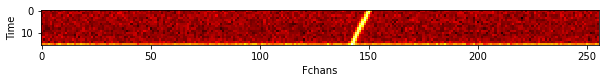

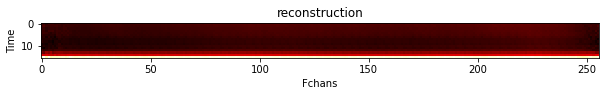

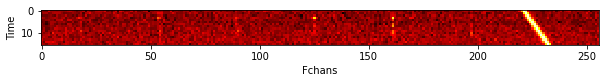

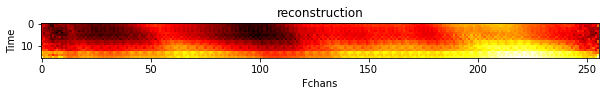

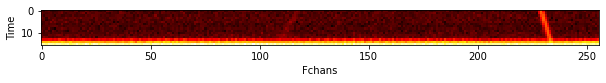

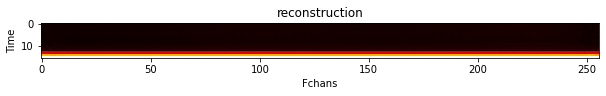

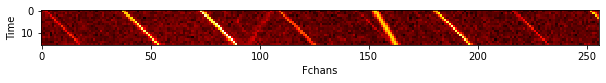

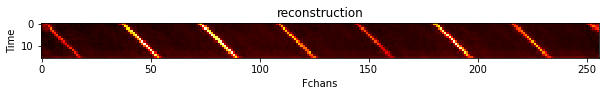

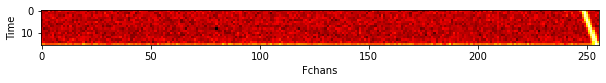

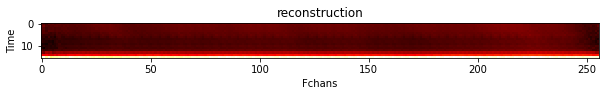

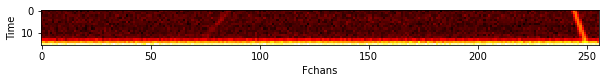

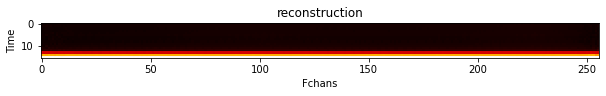

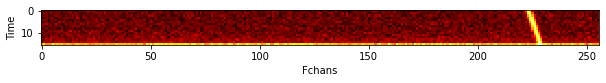

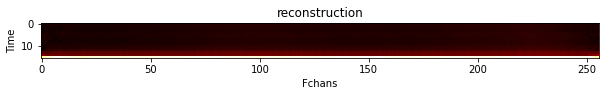

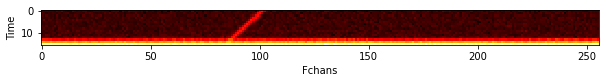

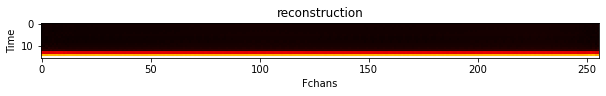

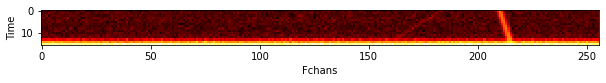

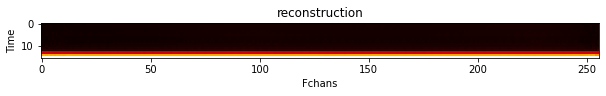

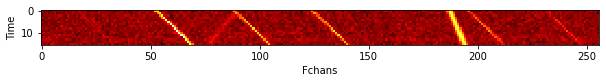

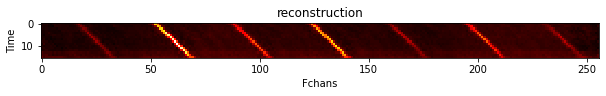

In [93]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*1000)
    plot_data = data[index:index+1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     print("-----------------------------------------------")